# Cogs 108 - Predictive Modeling of Heart Disease Risk

https://youtu.be/ABXqq7gNlTo?feature=shared

### Import Statements

In [1]:
# # OPTIONAL for Andy's computer b/c of environment issues
# import sys
# !{sys.executable} -m pip install --upgrade pip            
# !{sys.executable} -m pip install scipy seaborn matplotlib statsmodels
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install numpy

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
import lightgbm as lgb
import optuna
from lightgbm import early_stopping, log_evaluation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import optuna.logging

# COGS 108 - Final Project (change this to your project's title)

# Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ `X` ] YES - make available
* [  ] NO - keep private

# Names

- Andrew Gibson
- Sofia Morales-Fermin
- Samantha Lincoln
- Nayana Naineni
- Ananya Wasker
# Abstract

Cardiovascular disease remains the leading cause of death in the United States, yet risk manifests heterogeneously across comorbid populations. We used the 2020 CDC Behavioral Risk Factor Surveillance System “Key Indicators of Heart Disease” dataset (N = 319,795 adults, 17 demographic, lifestyle, and clinical variables) to ask two questions: 1) Does the predictive weight of traditional CVD risk factors differ between people with and without diabetes? and 2)Can we prospectively flag individuals who report no prior heart-disease diagnosis but nevertheless exhibit a high latent risk?

After data cleaning and randomly down-sampling the majority class to correct, the 0.91/0.09 class imbalance, we conducted exploratory analysis that confirmed previously established associations between heart disease and BMI, smoking, hypertension, and poor-self reported physical health. Then, we benchmarked the four classifiers of majority-class baseline, logistic regression, decision tree, and random forest, before optimizing a LightGBM model with stratified 5-fold cross-validation and Optuna hyper-parameter tuning. The tuned LightGBM achieved an overall accuracy of 93% and a macro F1-score of 0.78 on the held-out test set, which outperformed all baselines. Feature-importance scores showed that BMI, days of poor physical health, high blood pressure, and elevated cholesterol were dominant predictors in both cohorts, but advanced age contributed more strongly for non-diabetic participants. Applying the trained model to the 279,000 respondents who reported no prior heart disease diagnosis, we identified more than 17,000 adults with a predicted probability of ≥ 0.80. These high-risk individuals clustered around the same adverse lifestyle and clinical profiles as those with diagnosed heart disease, suggesting at the model’s face validity and potential for targeted early-intervention.

In summary, conventional risk factors remain prominent regardless of diabetes status, however, the degree to which each of these matters changes subtly with diabetes. The stratified LightGBM model efficiently runs large datasets and offers a scalable screening tool that can prioritize preventative care.

# Research Question

(1) **Does the predictive power of traditional risk factors (e.g., BMI, BP, cholesterol) differ between patients with and without diabetes?**

We plan on investigating disease-specific risk modeling, important for individualized care.

(2) **Among those with no reported history of heart disease, can we identify a high-risk group who "should" have it based on their profile, and investigate what may be protective (e.g., exercise)?**

We plan on exploring protective factors in "resilient" individuals and determining if there is a discernible “high-risk” group in not CVD patients.

## Background and Prior Work

**Background Research: Scientific Publications**

Cardiovascular disease (CVD) remains a leading cause of morbidity and mortality globally, with traditional risk factors such as high cholesterol, elevated BMI, hypertension, diabetes, smoking, and lack of exercise widely acknowledged as significant contributors. A study analyzing patients' knowledge of cardiovascular risk factors found that only about a third could correctly identify all the key health factors influencing cardiovascular health, highlighting substantial gaps in public awareness. Importantly, the study noted that patients with diabetes were more aware of their increased risk, although a significant portion (approximately 20%) remained unaware that diabetes itself is a risk factor for heart disease (Wartak et al., 2011).

Research has demonstrated variability in the predictive power of traditional risk factors depending on diabetic status. Echouffo-Tcheugui and Kengne (2013) reviewed multiple risk assessment models and observed a potential advantage for diabetes-specific models over models based on the general population. Their analysis indicated that models developed specifically for diabetics, such as UKPDS and ADVANCE, often provided more accurate risk predictions in diabetic patients, emphasizing the importance of making predictive tools disease-specific.

Further, a body of research has shown that not all individuals with diabetes experience the same level of cardiovascular risk. In 2015, Rana et al. found significant differences in CHD risk among diabetic individuals based on diabetes duration and presence of other cardiovascular risk factors, challenging the notion that diabetes alone confers a CHD risk equivalent to having prior coronary disease. This distinction is crucial for identifying high-risk groups without reported heart disease but whose risk profiles resemble those who have already experienced cardiac events.

These findings support our investigation into whether the predictive power of traditional cardiovascular risk factors differs based on diabetic status, and whether we can identify "resilient" individuals – those who remain heart disease-free despite having high-risk profiles. Addressing these questions could enhance targeted preventive strategies and refine individualized patient care.

Sources:
- Wartak et al., 2011: https://www.sciencedirect.com/science/article/pii/S0002914911003353
- Echouffo-Tcheugui and Kengne, 2013: https://www.sciencedirect.com/science/article/pii/S1262363613001298
- Rana et al., 2015: https://link.springer.com/article/10.1007/s11606-015-3556-3

**Background Research: Other Data Science Projects**

Aravind Pillai’s Kaggle notebook “Cardiac Disease Prediction with TabNet Deep Learn” applies TabNet architecture, which is a deep-learning model tailored for tabular data, and it was used to analyze the Cleveland heart-disease data set. The study preprocesses standard clinical features to train TabNet with k-fold cross-validation and report the model’s accuracy to be 80-82%. While the study shows that deep models are effective at capturing non-linear interactions from various risk-factors, the cohort group is treated as homogenous and does not evaluate performance separately from patients with or without diabetes. Moreover, the study also does not account for individuals that do not have any diseases despite having high-risk characteristics. The feature-ranking approach would be a great method to adopt for this project as it suggests a way to compare variability across subgroups. Furthermore, the analysis of the project could greatly benefit from making stratification models by diabetic status and then exploring groups with high-risk profiles but that do not have CVD.

Mario Caesar’s Kaggle notebook “Listen to Your Heart: A Disease Prediction” uses more traditional machine learning tools such as exploratory analysis, feature engineering, and ensemble classifiers on the same data set. The model was able to achieve accuracies of about 85-88%. The EDA uses correlations among BMI, max heart rate, and chest pain type, and the feature-selection process using established thresholds, like considering individuals with cholesterol greater than 240 mg/dL with elevated CVD risk. On the other hand, Caesar’s analysis focuses on overall prediction but does not account for subgroup differences or protective factors. This approach highlights the critical role of thorough EDA and how ensemble models can boost overall prediction accuracy. In contrast, our study looks at how those same risk factors manifest differently for patients with and without diabetes.

While Echouffo-Tcheugui and Kengne found that diabetes-specific cohorts often show improved calibration with data sets that only include diabetics, this method loses accuracy when applied to a more general population, where only a minority of the population has diabetes. This highlights concerns about overfitting and overgeneralizing when models are trained with just diabetic profiles. Moreover, much of the existing evidence is derived from observational cohorts, which puts models at potential risk of confounding variables such as variations in lifestyle, eating habits, comorbidities, etc. Inconsistencies in how certain key variables are measured highlights the importance of differencing results obtained from rigorous studies versus anecdotal examples. By critically evaluating these differing viewpoints and weighing how different methods can be applied to the data, we can ensure that the data is being analyzed using robust and reproducible evidence rather than unverified assumptions, like assuming that individuals with high cholesterol are at higher risk of having diabetes. This balanced perspective will strengthen the credibility of our findings.

Sources:
- Aravind Pillai, “Cardiac Disease Prevention with TabNet Deep Learn,” https://www.kaggle.com/code/aspillai/cardiac-disease-prediction-with-tabnet-deep-learn/notebook. Accessed April 29, 2025.
- Mario Ceasar, “Listen to Your Heart: A Disease Prediction,”  https://www.kaggle.com/code/caesarmario/listen-to-your-heart-a-disease-prediction. Accessed April 29, 2025.


# Hypothesis


For the first research question, we hypothesize that the predictive power of traditional cardiovascular risk factors such as BMI, blood pressure, and cholesterol levels will differ significantly between diabetic and non-diabetic individuals. Since diabetes is a chronic, metabolic disease that specifically affects the heart (among other organs) and is a severe risk to heart health, we expect these factors to have significantly stronger predictive associations with heart disease in non-diabetic patients when compared to diabetic patients and therefore better predictive power.

For the second research question, for individuals without a reported history of heart disease, we hypothesize that some subsets of people will, in fact, exhibit high-risk profiles based on their health and lifestyle data in the given dataset. We expect that protective factors such as frequent physical activity, healthy diet, or lower stress levels will be more common in these “resilient” high-risk individuals, serving as a buffer against disease development. Inversely, we hypothesize that individuals who do not have a history of heart disease but do exhibit less activity, high cholesterol, high stress levels, and other significant traits indicative of declining health are more susceptible to heart diseases developing in the future, which we want to predict from the dataset.

# Data Overview


- Dataset Name: **Key Indicators of Heart Disease**


- Link to the dataset: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease


- Number of observations: **319,795**


- Number of variables: **17**


This dataset comes from the U.S. Centers for Disease Control and Prevention (CDC), specifically the Behavioral Risk Factor Surveillance System (BRFSS). The survey collects health-related data annually via telephone interviews, which includes a variety of key health indicators that are known risk factors for heart disease.


Important variables include:


- ```HeartDisease``` (binary categorical): Target variable indicating presence of heart disease ("Yes"/"No").


- ```BMI``` (float): Body Mass Index.


- ```Smoking```, ```AlcoholDrinking```, ```Stroke```, ```DiffWalking```, ```Asthma```, ```KidneyDisease```, ```SkinCancer``` (binary categorical): Key lifestyle factors and pre-existing health conditions.


- ```PhysicalHealth```, ```MentalHealth``` (float): Number of days with poor physical/mental health in the past month.


- ```Sex```, ```AgeCategory```, ```Race```, ```Diabetic```, ```PhysicalActivity```, ```GenHealth``` (categorical): Demographic and self-reported health status.


- ```SleepTime``` (float): Average hours of sleep.

## Dataset: Indicators of Heart Disease CDC 2020

In [3]:
heart_disease_dataset = pd.read_csv(r'data/heart_2020_cleaned.csv')
heart_disease_dataset.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
heart_disease_dataset.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


## Data Cleaning and Preprocessing

### Dropping Columns and Null Values

The first step in data cleaning involves an assessment of relevant variables and checking for null values. This helps us narrow our focus to the research question and remove rows of null values. After checking for null values, we find that this dataset has already been cleaned by its creator and therefore contains no nulls. Columns to be dropped in this dataset and the reasons for dropping them are:
-   ``` DiffWalking ``` : This points to problems with physiological health, which is covered already by the ``` PhysicalHealth ``` and ``` PhysicalActivity ``` columns, thus we drop it due to redundancy.

- ``` KidneyDisease ``` : This is irrelevant to our research question as it does not fall into our criteria for risk factors.

- ``` SkinCancer ``` : We drop this for the same reason as above, as our variables focus largely on lifestyle + demographic factors.

In [5]:
# keep relevant columns

columns = ['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 
           'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma']
heart_disease_dataset = heart_disease_dataset[columns]
print('Heart Disease New Columns:')
print(np.array(heart_disease_dataset.columns))

Heart Disease New Columns:
['HeartDisease' 'BMI' 'Smoking' 'AlcoholDrinking' 'Stroke'
 'PhysicalHealth' 'MentalHealth' 'Sex' 'AgeCategory' 'Race' 'Diabetic'
 'PhysicalActivity' 'GenHealth' 'SleepTime' 'Asthma']


In [6]:
# check for nulls
print('Are there null values in the new dataset with relevant columns?')
print(heart_disease_dataset.isna().any())

Are there null values in the new dataset with relevant columns?
HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
dtype: bool


### Changing Column Values To Binary

By looking at the dataset, we see that most columns have string values of 'Yes' and 'No'. Using the process of binary encoding, we can convert these categorical variables to numerical values, with 'Yes' mapping 1 and 'No' mapping to 0. We do this categorical encoding primarily to later aid our models which would need numerical inputs, but also to save space and represent our data efficiently.

In [7]:
# changing yes and no to 1 and 0

columns_encode = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalActivity', 'Asthma']

for col in columns_encode:
    heart_disease_dataset[col] = heart_disease_dataset[col].astype(str).str.strip().str.lower()
    yes_no_map_lower = {'yes': 1, 'no': 0}
    heart_disease_dataset[col] = heart_disease_dataset[col].map(yes_no_map_lower)

heart_disease_dataset

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma
0,0,16.60,1,0,0,3.0,30.0,Female,55-59,White,Yes,1,Very good,5.0,1
1,0,20.34,0,0,1,0.0,0.0,Female,80 or older,White,No,1,Very good,7.0,0
2,0,26.58,1,0,0,20.0,30.0,Male,65-69,White,Yes,1,Fair,8.0,1
3,0,24.21,0,0,0,0.0,0.0,Female,75-79,White,No,0,Good,6.0,0
4,0,23.71,0,0,0,28.0,0.0,Female,40-44,White,No,1,Very good,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,Male,60-64,Hispanic,Yes,0,Fair,6.0,1
319791,0,29.84,1,0,0,0.0,0.0,Male,35-39,Hispanic,No,1,Very good,5.0,1
319792,0,24.24,0,0,0,0.0,0.0,Female,45-49,Hispanic,No,1,Good,6.0,0
319793,0,32.81,0,0,0,0.0,0.0,Female,25-29,Hispanic,No,0,Good,12.0,0


### Changing AgeCategory and GenHealth Columns

We also must change the Age Category, which is currently of  ```str```  type, to a midpoint age of the category and a number. After looking at all the unique values in this column, we can determine that except  ```80 or older```, the midpoint of each category can be computed. For this category, however, we can change it directly to the number ```85``` to reflect the general expected ages of that category (for example, 100 years old is not a reasonable average age to expect from this category).

In the ```GenHealth``` column, we see string inputs like 'Very Good', 'Fair', 'Poor' etc. The five unique values can also be converted to numbers, from a range of 1-5.

In [8]:
heart_disease_dataset['AgeCategory'].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

In [9]:
# splitting strings into 2 integers, calculating midpoint age, and applying this function to the column

def clean_age(age_str):
    if 'or older' in age_str:
        return 85
    else:
        parts = age_str.split('-')
        low = int(parts[0])
        high = int(parts[1])
        return (low + high) / 2

heart_disease_dataset['Age'] = heart_disease_dataset['AgeCategory'].apply(clean_age)
heart_disease_dataset = heart_disease_dataset.drop(['AgeCategory'], axis=1)

In [10]:
# scoring GenHealth from 1-5 and changing the column

gen_health_map = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
}

heart_disease_dataset['GenHealthScore'] = heart_disease_dataset['GenHealth'].map(gen_health_map)
heart_disease_dataset = heart_disease_dataset.drop('GenHealth', axis=1)
heart_disease_dataset = heart_disease_dataset.rename(columns={'GenHealthScore':'GenHealth'})

print('Cleaned Dataset:')
heart_disease_dataset

Cleaned Dataset:


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,Sex,Race,Diabetic,PhysicalActivity,SleepTime,Asthma,Age,GenHealth
0,0,16.60,1,0,0,3.0,30.0,Female,White,Yes,1,5.0,1,57.0,4
1,0,20.34,0,0,1,0.0,0.0,Female,White,No,1,7.0,0,85.0,4
2,0,26.58,1,0,0,20.0,30.0,Male,White,Yes,1,8.0,1,67.0,2
3,0,24.21,0,0,0,0.0,0.0,Female,White,No,0,6.0,0,77.0,3
4,0,23.71,0,0,0,28.0,0.0,Female,White,No,1,8.0,0,42.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,Male,Hispanic,Yes,0,6.0,1,62.0,2
319791,0,29.84,1,0,0,0.0,0.0,Male,Hispanic,No,1,5.0,1,37.0,4
319792,0,24.24,0,0,0,0.0,0.0,Female,Hispanic,No,1,6.0,0,47.0,3
319793,0,32.81,0,0,0,0.0,0.0,Female,Hispanic,No,0,12.0,0,27.0,3


## Descriptive Analysis

With the following tools, we look deeper into the dataset to understand summary statistics, outlier info, unique values etc. With ```.describe()```, we see the summary statistics for all numeric columns. The count for each is the same, which means we have no null values. We also see that the mean BMI of the dataset (28.32) matches up to the reported mean BMI of adults in the United (29.27). 

Furthermore, we see that while the maximum number of bad mental-health and physical-health days is the max score of 30/30, the mean for both is much lower and is in the 3.3-3.9 range, which reflects the average person's experience. Similarly, the sleep time of 7 hours is reasonable. Looking at Age and GenHealth averages, we see that the average age of participants in this CDC survey was 54.7 years old while the GenHealth fell at 3.6/5, between 'Good' and 'Very Good'.


We also use ```.info()``` to check the data types of each column and confirm that there are no missing values.

In [11]:
info_df = pd.DataFrame({
    'Column': heart_disease_dataset.columns,
    'Non-Null Count': heart_disease_dataset.notnull().sum().values,
    'Dtype': heart_disease_dataset.dtypes.values
})

desc_df = heart_disease_dataset.describe().T

print('\nDescribe Summary:\n')
display(desc_df)
print('Info Summary:\n')
display(info_df)


Describe Summary:



,count,mean,std,min,25%,50%,75%,max
HeartDisease,319795.0,0.085595,0.279766,0.00,0.00,0.00,0.00,1.00
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
Smoking,319795.0,0.412477,0.492281,0.00,0.00,0.00,1.00,1.00
AlcoholDrinking,319795.0,0.068097,0.251912,0.00,0.00,0.00,0.00,1.00
Stroke,319795.0,0.037740,0.190567,0.00,0.00,0.00,0.00,1.00
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
PhysicalActivity,319795.0,0.775362,0.417344,0.00,1.00,1.00,1.00,1.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00
Asthma,319795.0,0.134061,0.340718,0.00,0.00,0.00,0.00,1.00


Info Summary:



,Column,Non-Null Count,Dtype
0,HeartDisease,319795,int64
1,BMI,319795,float64
2,Smoking,319795,int64
3,AlcoholDrinking,319795,int64
4,Stroke,319795,int64
5,PhysicalHealth,319795,float64
6,MentalHealth,319795,float64
7,Sex,319795,object
8,Race,319795,object
9,Diabetic,319795,object


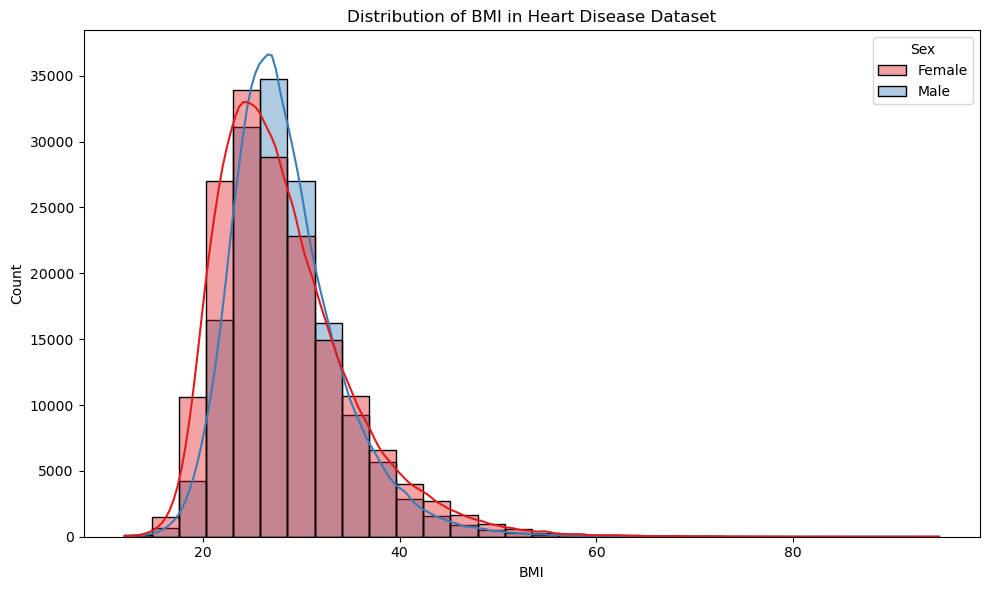

In [12]:
plt.figure(figsize=(10, 6))

# histogram: plotting the BMI distribution in seaborn
sns.histplot(
    data=heart_disease_dataset,
    x='BMI',
    hue='Sex',
    bins=30,        
    kde=True,        
    palette='Set1',  
    alpha=0.4      # adjusted transparency of the bars
)

plt.title('Distribution of BMI in Heart Disease Dataset')
plt.xlabel('BMI')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

As part of our initial data quality checks, we plotted the distribution of BMI, one of the key risk factors for heart disease and a significant variable in our modeling. Most individuals clustered within the expected normal to overweight range, with a noticeable long tail representing individuals in the obese category. This distribution, which is normally distributed, aligns with our expectations for a large, nationally representative health dataset, supporting its validity for subsequent modeling!

# Results

## Exploratory Data Analysis

### Exploring Demographic Variables

First, we check the strenght of correlation between the variables of ```Age```,  ```Race```,  ```Sex```, and ```HeartDisease``` across the two groups of Diabetics and Non-Diabetics. We can do this with the help of insightful visualizations like BoxPlots, which show us how different the relationship between Age and HeartDisease is across the 4 diabetic categories.

Additionally, we want to see how the rate of heart disease is different across 'Race' and 'Sex' columns for each diabetic category. We can use heatmps for this purpose, as each cell contains the proportion of people within that Race and Sex group who have heart disease, with darker colors indicating higher prevalence.

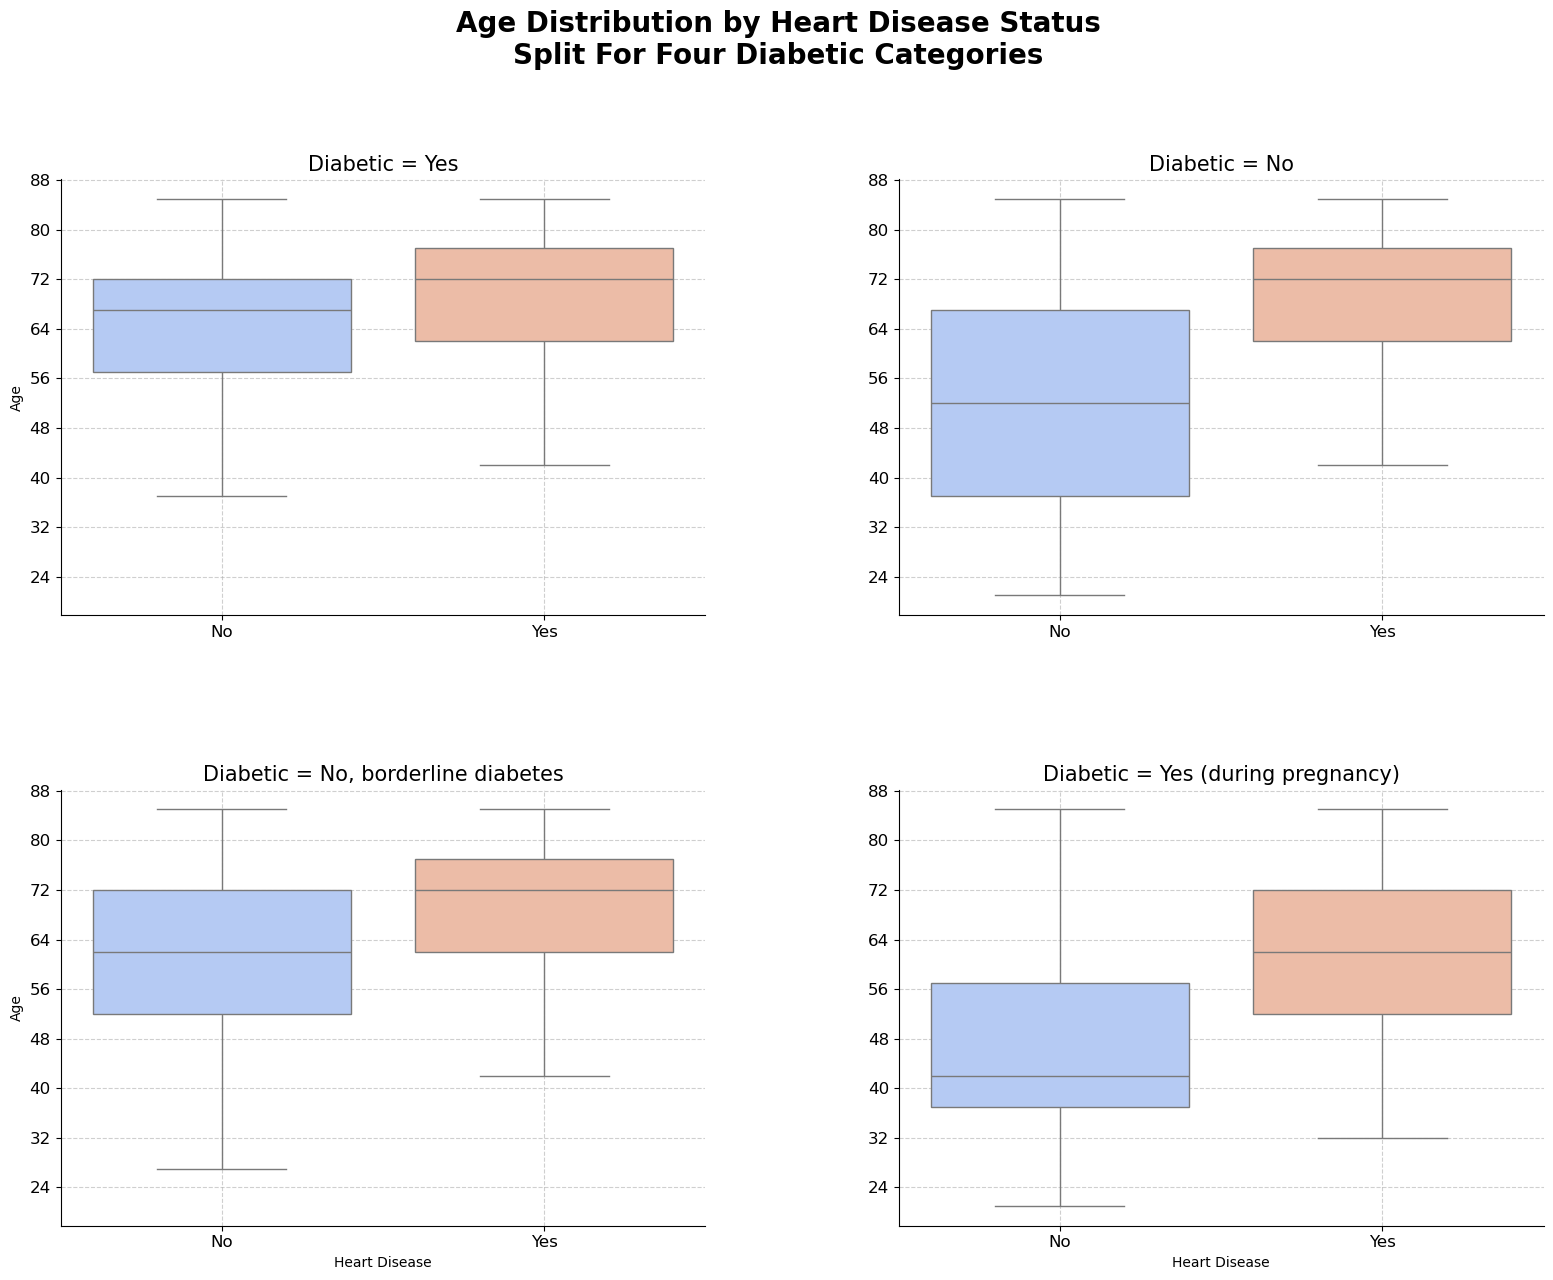

In [13]:
import matplotlib.ticker as ticker

g = sns.catplot(
    data=heart_disease_dataset,
    kind="box",
    x="HeartDisease",
    y="Age",
    hue="HeartDisease",
    col="Diabetic",
    col_wrap=2,
    height=6.5,
    aspect=1.2,
    palette="coolwarm",
    showfliers=False,
    legend=False
)
for ax in g.axes.flat:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'], fontsize=12)
    ax.tick_params(axis='x', labelbottom=True)  # force show x-axis labels

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelleft=True, labelsize=12)  # force show y-axis labels

    ax.grid(True, linestyle='--', alpha=0.6)

g.set_titles("Diabetic = {col_name}", size=15)
g.set_axis_labels("Heart Disease", "Age")

for ax in g.axes.flat:
    ax.grid(True, linestyle="--", alpha=0.6)

g.fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)
g.fig.suptitle("Age Distribution by Heart Disease Status\nSplit For Four Diabetic Categories", fontsize=20, weight="bold")
plt.show()

In this section we will explore variables for a) heart disease, with and without diabetes for physical health and b) heart disease, with and without diabetes, for mental health using two sets of boxplots.


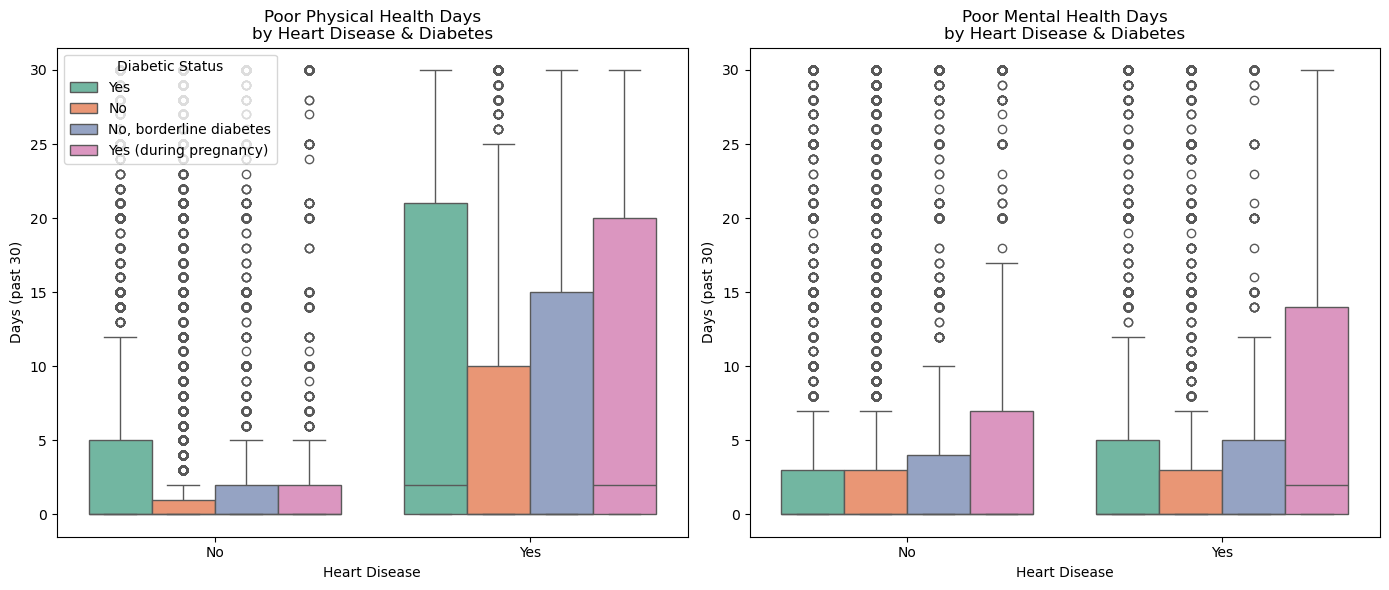

In [14]:
df = heart_disease_dataset.copy()
df['HeartDisease'] = df['HeartDisease'].map({0: 'No', 1: 'Yes'})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# a) physical health
sns.boxplot(
    data=df,
    x='HeartDisease',
    y='PhysicalHealth',
    hue='Diabetic',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title('Poor Physical Health Days\nby Heart Disease & Diabetes')
axes[0].set_xlabel('Heart Disease')
axes[0].set_ylabel('Days (past 30)')
axes[0].legend(title='Diabetic Status', loc='upper left')

# b) mental health
sns.boxplot(
    data=df,
    x='HeartDisease',
    y='MentalHealth',
    hue='Diabetic',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title('Poor Mental Health Days\nby Heart Disease & Diabetes')
axes[1].set_xlabel('Heart Disease')
axes[1].set_ylabel('Days (past 30)')
axes[1].legend_.remove()   # only show one legend

plt.tight_layout()
plt.show()

When we break the sample into four diabetes groups (“Yes,” “No,” “Borderline,” and “Yes — during pregnancy”) two patterns stand out. First, physical health: across every diabetes group the people who also report heart disease (orange boxes) say they felt physically unwell far more days in the last month than those without heart disease (blue boxes). For example, full diabetics with heart disease cluster around 15-20 bad-health days, while diabetics without heart disease cluster near 0-5. This gap is visible—though smaller, for non, diabetics and borderline cases, and it shows up again for the small pregnancy-related subgroup. Second, mental health: the difference between heart-disease and non-heart-disease groups is much smaller. Most boxes stay below 5 bad-mental-health days, and the median barely shifts when heart disease is present, except in the pregnancy-related group where everyone reports noticeably higher mental-health distress. In short, heart disease strongly tracks with worse physical well-being regardless of diabetes status, but its link to mental well-being is weaker and may only surface in specific sub-populations.


Interestingly for our research question, diabetes status does seem to modulate how well self‐reported “poor health” days discriminate heart disease cases, especially for physical health:

- **Physical health days:** The jump in mean poor‐health days between those without and with heart disease grows slightly as you move from non-diabetic (Δ≈4.1 days) to full diabetic (Δ≈4.2 days) to pregnant diabetic individuals (Δ≈5.9 days). That is, physical‐health days are a decent signal of heart disease for everyone, but even more so among people with diabetes—particularly gestational diabetes. In practice, a model that uses “days of poor physical health” will have marginally better predictive power within diabetic subgroups than in non-diabetics.

- **Mental health days:** The heart-disease vs. non-heart-disease gap is small for non-diabetics (Δ≈0.5 days) and full diabetics (Δ≈1.0 days), but larger in the pregnant-diabetic group (Δ≈2.3 days). This suggests poor mental health is generally a weaker predictor of heart disease, except perhaps in that specific subgroup.

In [16]:
print('Summary Statistics for Heart Disease and Diabetes: ')
heart_disease_dataset.groupby(['HeartDisease', 'Diabetic'])['BMI'].describe()

Summary Statistics for Heart Disease and Diabetes: 


count       mean       std    min  \
HeartDisease Diabetic                                                        
0            No                       252134.0  27.721877  6.029632  12.02   
             No, borderline diabetes    5992.0  30.412380  7.003043  13.02   
             Yes                       31845.0  31.739549  7.162799  12.53   
             Yes (during pregnancy)     2451.0  28.929612  6.987156  13.82   
1            No                        17519.0  28.226499  6.023079  12.21   
             No, borderline diabetes     789.0  30.747845  6.749821  16.31   
             Yes                        8957.0  31.593930  7.001859  12.84   
             Yes (during pregnancy)      108.0  28.359907  6.702513  12.84   

                                        25%     50%      75%    max  
HeartDisease Diabetic                                                
0            No                       23.63  26.630  30.6700  94.85  
             No, borderline diabetes  25.69  29.290  33.9950  79.00  
             Yes                      26.63  30.670  35.4800  93.86  
             Yes (during pregnancy)   23.79  27.470  32.6100  65.08  
1            No                       24.33  27.340  31.1900  83.33  
             No, borderline diabetes  26.05  29.910  34.3300  61.70  
             Yes                      26.78  30.520  35.2600  77.73  
             Yes (during pregnancy)   24.03  27.425  31.5125  52.43

Here, from the descriptive information from the dataset, we can see that on average, individuals with both diabetes and heart disease had the highest BMI (mean = 31.74), compared to those with no diabetes or heart disease (mean = 27.72). Surprisingly enough, people with heart disease without diabetes had a lower mean BMI (28.23) than diabetic individuals without heart disease (30.41–30.75). This could mean that having a higher BMI might increase heart disease risk more in people with diabetes than in individuals without diabetes. Those who had diabetes during pregnancy generally had lower BMIs with heart disease and without heart disease, proving that other factors may be at play. Additionally, while looking at both diabetic as well as non-diabetic people, we can observe that the average BMI of those with heart disease is higher than those without. This is similarly shown with individuals with and without heart disease, whilst looking at diabetic compared to non-diabetic people. This makes sense scientifically, as high BMI is known to have a relationship with both diabetes and heart disease independently. These results suggest that BMI's relationship with heart disease is dependent on diabetes status, as individuals with heart disease often tend to have higher BMI values, and this impact is intensified in those with diabetes. Therefore, both diabetes and heart disease prove to share underlying risk factors related to obesity.

We will now focus on stroke variables in relation to diabetes and heart disease.

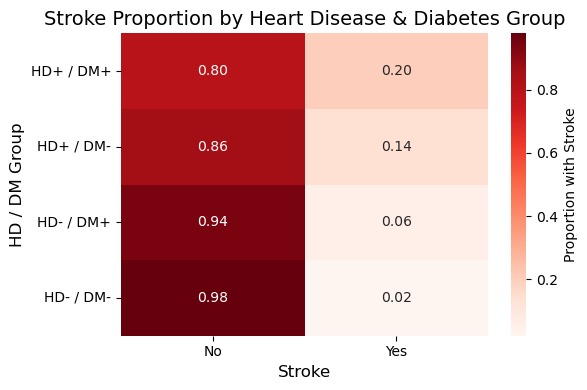

In [17]:
heart_disease_dataset['Diabetic_Simple'] = (
    heart_disease_dataset['Diabetic']
    .apply(lambda x: 'DM+' if x.startswith('Yes') else 'DM-')
)

heart_disease_dataset['HD_Simple'] = heart_disease_dataset['HeartDisease'].map({0: 'HD-', 1: 'HD+'})
combo_label = heart_disease_dataset['HD_Simple'] + ' / ' + heart_disease_dataset['Diabetic_Simple']

crosstab = pd.crosstab(
    combo_label,
    heart_disease_dataset['Stroke'].map({0: 'No', 1: 'Yes'})
)

proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    proportions,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={'label': 'Proportion with Stroke'}
)
plt.title("Stroke Proportion by Heart Disease & Diabetes Group", fontsize=14)
plt.ylabel("HD / DM Group", fontsize=12)
plt.xlabel("Stroke", fontsize=12)
plt.tight_layout()
plt.show()

The heatmap displays, for each combined heart-disease/diabetes group, the proportion who have ever had a stroke. In the HD−/DM− group, only about 2% report a stroke, rising to 6% in HD−/DM+ (diabetes alone), 14% in HD+/DM− (heart disease alone), and peaking at 20% when both conditions coexist. The clear upward gradient—from dark red in the “No stroke” column for HD−/DM− to the lighter red in the “Yes stroke” column for HD+/DM+—illustrates how heart disease and diabetes each independently exacerbate stroke risk, and how their combination leads to the highest vulnerability.


Finally, we will explore the presence of healthy lifestyles (smoking, drinking alcohol, and physical activity) in groups with combinations of heart disease and diabetes mellitus (DM).


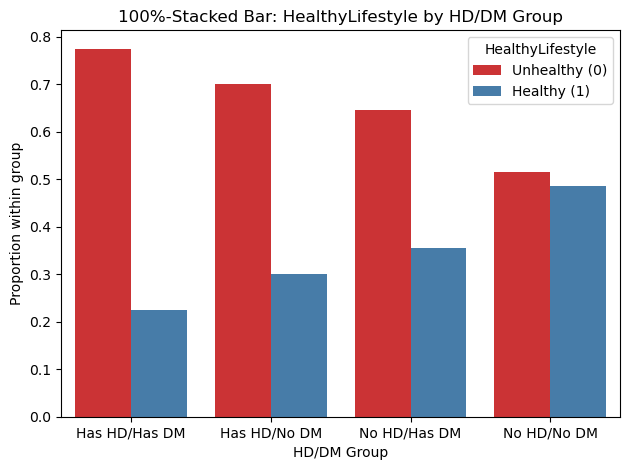

In [18]:
df = heart_disease_dataset.copy()
yes_no_cols = ["HeartDisease", "Diabetic",
               "Smoking", "AlcoholDrinking", "PhysicalActivity"]
normaliser = {"yes": "Yes", "y": "Yes", "1": "Yes", "true": "Yes", True: "Yes",
              "no": "No",  "n": "No",  "0": "No",  "false": "No",  False: "No"}
for col in yes_no_cols:
    df[col] = (
        df[col]                    
          .astype(str)           
          .str.strip()          
          .str.lower()          
          .map(normaliser)
    )
df["HealthyLifestyle"] = (
    (df["Smoking"]          == "No") &
    (df["AlcoholDrinking"]  == "No") &
    (df["PhysicalActivity"] == "Yes")
).astype(int)
hd_map = {"No": "No HD",  "Yes": "Has HD"}
dm_map = {"No": "No DM",  "Yes": "Has DM"}
df["HD_DM_Group"] = (
    df["HeartDisease"].map(hd_map) + "/" +
    df["Diabetic"].map(dm_map)
)
plot_df = (
    df
    .groupby("HD_DM_Group")["HealthyLifestyle"]
    .value_counts(normalize=True)
    .rename("prop")
    .reset_index()
)
ax = sns.barplot(            
        x="HD_DM_Group",
        y="prop",
        hue="HealthyLifestyle",
        data=plot_df,
        palette="Set1"
)
ax.set_ylabel("Proportion within group")
ax.set_xlabel("HD/DM Group")
ax.set_title("100%-Stacked Bar: HealthyLifestyle by HD/DM Group")
handles, labels = ax.get_legend_handles_labels()  
label_map = {"0": "Unhealthy (0)", "1": "Healthy (1)"}
ax.legend(handles,
          [label_map[l] for l in labels],
          title="HealthyLifestyle")
plt.tight_layout()
plt.show()

This 100%-stacked bar chart breaks down each HD and DM subgroup by the Healthy Lifestyle flag, where blue signifies that it meets all the criteria whereas red does not. There is a clear gradient in the prevalence of a healthy lifestyle: only 23% of those with HD and DM qualify as healthy whereas 78% does not, healthy lifestyle increases to 30% of those with HD but not DM, healthy lifestyle rises further to 35% of those with DM but not HD, and 48% with neither HD and DM meet the healthy-lifestyle criteria. Individuals without both HD and DM are more than twice as likely to follow a healthy lifestyle compared to those with both conditions. Moreover, healthy lifestyle monotonically declines cardiometabolic burden increases.


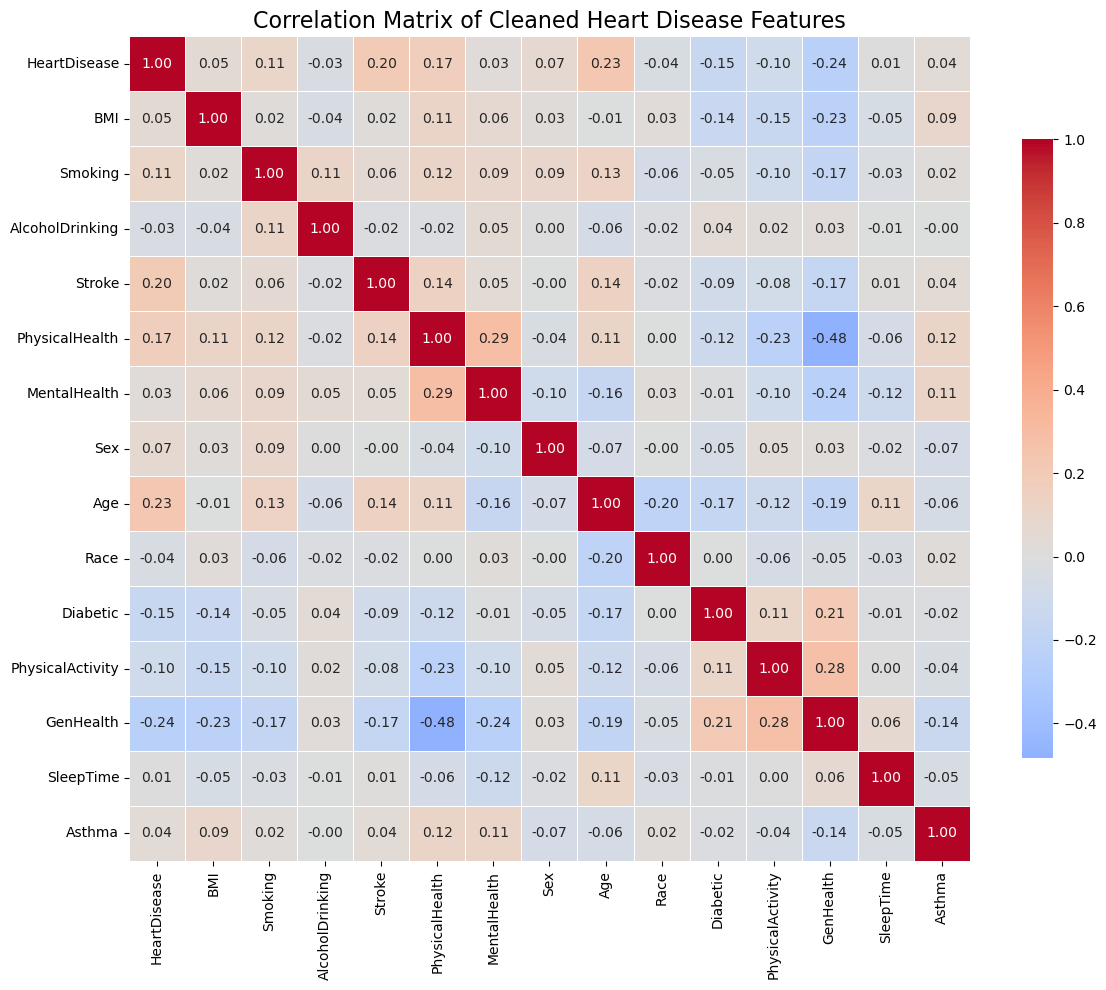

In [19]:
# select the cleaned columns
cols = [
    'HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
    'PhysicalHealth', 'MentalHealth', 'Sex', 'Age', 'Race',
    'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma'
]
df_sub = heart_disease_dataset[cols].copy()

# factorize remaining categorical columns
for col in df_sub.select_dtypes(include=['object','category']).columns:
    df_sub[col], _ = pd.factorize(df_sub[col])

corr = df_sub.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': .75}
)
plt.title("Correlation Matrix of Cleaned Heart Disease Features", fontsize=16)
plt.tight_layout()
plt.show()


This heatmap highlights the importance of individual risk factors to heart disease. Age has the strongest positive association (r≈0.23): older respondents report more heart disease. Stroke history also correlates positively (r≈0.20), which makes sense clinically. Days of poor physical health (r≈0.17) and smoking (r≈0.11) are the next‐strongest positive correlates.

In contrast, self‐rated general health shows the largest negative correlation (r≈–0.24): people who rate their health as “excellent” are much less likely to report heart disease. Physical activity is modestly inversely correlated (r≈–0.10), suggesting an exercise‐protective effect. All other single factors—BMI, mental‐health days, alcohol use, sleep time, even asthma—have only very weak correlations (|r|<0.1) with heart disease in this cross‐sectional data.

Unfortunately, this heatmap alone does not yield insights on how diabetes might mediate heart disease risk or risk factors because correlation misses interaction and mediation. Even if we binarized diabetes, a flat correlation captures only linear co‐movement; it won’t show us that, say, “days of poor physical health” are more predictive of heart disease within diabetics than non‐diabetics (which our stratified boxplots and heatmaps earlier did reveal).

# Inferential Analysis

We will now conduct an inferential analysis using logistic regression, VIF-multicollinearity, and Cook’s Distance to enhance our understanding of the relationships between individual risk factors and heart disease. This will allow us to estimate the independent associations of key predictors—including diabetes status, age, BMI, smoking, physical activity, and general health—with the likelihood of heart disease.

In [20]:
df = heart_disease_dataset.copy()

df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

df['HeartDisease'] = df['HeartDisease'].astype(int)

formula = 'HeartDisease ~ DiabeticFlag + Age + BMI + Smoking + PhysicalActivity + GenHealth'

logit_model = smf.logit(formula, data=df).fit(disp=False)
print(logit_model.summary())

params = logit_model.params
conf = logit_model.conf_int()
or_df = pd.DataFrame({
    'OR': np.exp(params),
    'CI Lower': np.exp(conf[0]),
    'CI Upper': np.exp(conf[1])
})
print('\nOdds Ratios with 95% CI')
print(or_df)

poisson_model = smf.glm(
    formula,
    data=df,
    family=sm.families.Poisson()
).fit(cov_type='HC3', disp=False)

print(poisson_model.summary())

p_params = poisson_model.params
p_conf = poisson_model.conf_int()
rr_df = pd.DataFrame({
    'RR': np.exp(p_params),
    'CI Lower': np.exp(p_conf[0]),
    'CI Upper': np.exp(p_conf[1])
})
print('\nRisk Ratios with 95% CI')
print(rr_df)

                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319788
Method:                           MLE   Df Model:                            6
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.1911
Time:                        19:29:16   Log-Likelihood:                -75594.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.4271      0.059    -75.142      0.000      -4.543      -4.312
DiabeticFlag         0.5812      0.016     36.528      0.000       0.550       0.612
Age                  0.0529 

The logistic regression results indicate that diabetes is a strong and statistically significant predictor of heart disease, even after adjusting for age, BMI, smoking, physical activity, and general health. Specifically, individuals with diabetes have approximately 79% higher odds of reporting heart disease than non-diabetics (OR = 1.79, 95% CI [1.73, 1.84], p < 0.001). Age and BMI are also positively associated with heart disease risk, with each additional year of age increasing the odds by about 5%, and each unit increase in BMI raising the odds by roughly 1.3%. Smoking is another significant risk factor, associated with a 60% increase in odds of heart disease. In contrast, better self-rated general health is strongly protective: for each one-unit increase on the five-point health scale (from “Poor” to “Excellent”), the odds of heart disease decrease by about 39%. Physical activity shows a small, non-significant association. Overall, the model suggests that diabetes substantially contributes to heart disease risk independent of traditional health and lifestyle factors.

This is a strong initial indicator that diabetes is a predictor of heart disease, but further work is needed to confirm these findings. We will now conduct Poisson GLM with robust standard errors (“modified Poisson”) to estimate risk ratios (RRs) for a binary outcome directly. This is preferable when the outcome is not very rare, because RRs are easier to interpret than odds ratios.

Now we are going to implement a VIF-based multicollinearity check and a stratified sensitivity check (e.g. split by sex or age), since those are quickest and most likely to reveal whether our baseline result is robust or not. If both pass, then we will add a single interaction term (e.g. DiabeticFlag × PhysicalHealth) to confirm the diabetes risk is not strongly conditional on poor health days. Together, these steps will triangulate our inference by showing (1) the effect holds in subgroups, (2) it isn’t an artifact of collinearity or outliers, and (3) it doesn’t rise or fall dramatically when interacted with another predictor.


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = heart_disease_dataset.copy()

if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

required = ['Age', 'BMI', 'Smoking', 'PhysicalActivity', 'GenHealth']
missing = [col for col in required if col not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for VIF: {missing}")

df_vif = df[['DiabeticFlag', 'Age', 'BMI', 'Smoking', 'PhysicalActivity', 'GenHealth']].copy()

# non-numeric columns to numeric
for col in ['Smoking', 'PhysicalActivity']:
    if df_vif[col].dtype == 'object':
        df_vif[col] = df_vif[col].str.strip().str.lower().map({'yes': 1, 'no': 0})

df_vif = sm.add_constant(df_vif)

vif_data = []
for i, col in enumerate(df_vif.columns):
    vif_data.append({
        'variable': col,
        'VIF': variance_inflation_factor(df_vif.values, i)
    })

vif_df = pd.DataFrame(vif_data)

print(vif_df)

           variable        VIF
0             const  62.659297
1      DiabeticFlag   1.145332
2               Age   1.087959
3               BMI   1.096092
4           Smoking   1.043776
5  PhysicalActivity   1.106366
6         GenHealth   1.232619


In [ ]:
df = heart_disease_dataset.copy()

if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)
df['HeartDisease'] = df['HeartDisease'].astype(int)

strata = {
    'Male': df[df['Sex'] == 'Male'],
    'Female': df[df['Sex'] == 'Female']
}

results = {}
for label, dsub in strata.items():
    
    if len(dsub) < 50:
        continue

    formula = 'HeartDisease ~ DiabeticFlag + Age + BMI + Smoking + PhysicalActivity + GenHealth'
    model = smf.logit(formula, data=dsub).fit(disp=False)

    coef = model.params['DiabeticFlag']
    conf_lower, conf_upper = model.conf_int().loc['DiabeticFlag']

    or_val = np.exp(coef)
    ci_lower, ci_upper = np.exp(conf_lower), np.exp(conf_upper)

    results[label] = {
        'OR': or_val,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper,
        'p-value': model.pvalues['DiabeticFlag']
    }

stratified_df = pd.DataFrame(results).T
print("Stratified Logistic Regression (DiabeticFlag effect by Sex):")
print(stratified_df)

Stratified Logistic Regression (DiabeticFlag effect by Sex):
              OR  CI Lower  CI Upper        p-value
Male    1.696059  1.626990  1.768060  6.469571e-137
Female  1.763157  1.680617  1.849752  6.779500e-119


The Variance Inflation Factor (VIF) results indicate that none of the predictors (DiabeticFlag, Age, BMI, Smoking, PhysicalActivity, GenHealth) suffer from problematic multicollinearity—each VIF is close to 1, meaning each variable contributes largely independent information. The only high VIF is the constant term, which is expected since it captures the model intercept. In the stratified logistic regressions, the odds ratios (ORs) for DiabeticFlag are 1.70 (95% CI: 1.63–1.77) in males and 1.76 (95% CI: 1.68–1.85) in females, both highly significant (p < 10⁻¹¹⁸). These similar ORs show that diabetes increases the odds of heart disease by about 70–76% in both men and women, suggesting the relationship is consistently strong across sexes.

Now we'll compute Cook’s distance and leverage to identify whether any individual observations are disproportionately affecting our logistic‐regression estimates. If a few data points have very large Cook’s values or unusually high leverage, they could be driving the apparent diabetes effect; checking these diagnostics helps ensure our findings aren’t unduly influenced by outliers.

In [ ]:
df = heart_disease_dataset.copy()
if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)
df['HeartDisease'] = df['HeartDisease'].astype(int)

formula = 'HeartDisease ~ DiabeticFlag + Age + BMI + Smoking + PhysicalActivity + GenHealth'
model = smf.logit(formula, data=df).fit(disp=False)

influence = model.get_influence()

cooks, _ = influence.cooks_distance

leverage = influence.hat_matrix_diag

dfbetas = influence.dfbetas

infl_df = pd.DataFrame({
    'cooks_distance': cooks,
    'leverage': leverage,
    'dfbeta_DiabeticFlag': dfbetas[:, list(model.params.index).index('DiabeticFlag')]
})

n = df.shape[0]
p = len(model.params) - 1
cooks_threshold = 4 / n
leverage_threshold = 2 * (p + 1) / n

infl_df['high_cooks'] = infl_df['cooks_distance'] > cooks_threshold
infl_df['high_leverage'] = infl_df['leverage'] > leverage_threshold

top_cooks = infl_df.sort_values('cooks_distance', ascending=False).head(10)
print("Top 10 observations by Cook’s distance:")
print(top_cooks)

high_leverage_points = infl_df[infl_df['high_leverage']]
print(f"\nNumber of high-leverage points: {high_leverage_points.shape[0]}")

Top 10 observations by Cook’s distance:
        cooks_distance  leverage  dfbeta_DiabeticFlag  high_cooks  \
201173        0.000555  0.000019            -0.012321        True   
242246        0.000376  0.000228            -0.013974        True   
184779        0.000338  0.000068            -0.011080        True   
79545         0.000329  0.000235            -0.012755        True   
156093        0.000308  0.000986             0.003483        True   
249715        0.000301  0.000968             0.003995        True   
63400         0.000279  0.000036            -0.010398        True   
290183        0.000266  0.001020             0.013922        True   
9358          0.000257  0.000263             0.001082        True   
70594         0.000240  0.000382            -0.011893        True   

        high_leverage  
201173          False  
242246           True  
184779           True  
79545            True  
156093           True  
249715           True  
63400           False  
290183  

Even the “most influential” points have extremely small Cook’s distances (all <0.001) and only trivial impacts on the diabetes coefficient (DFBeta ≈ ±0.01), indicating that no single observation is unduly driving the diabetes–heart disease effect. Although nearly 47,000 rows exceed the leverage threshold, their leverage values remain very low in absolute terms, so these high‐leverage cases do not substantially distort the model. In other words, the estimated increase in heart‐disease risk associated with diabetes is robust and not the result of a few outliers!



**Figure:** *Logistic regression of the probability of diabetes as a function of days of poor physical health.* Each point represents an individual’s diabetic status (0 = no, 1 = yes), and the red curve shows the fitted logistic trend, indicating that the likelihood of diabetes increases modestly as the number of poor‐health days rises.

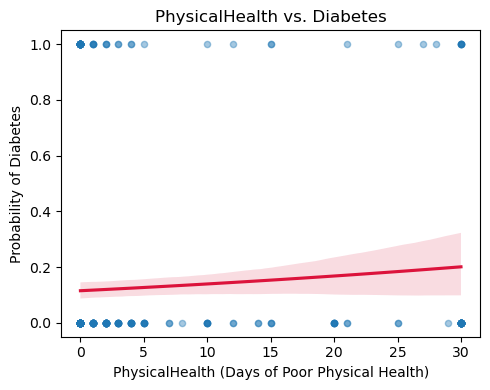

In [ ]:
df = heart_disease_dataset.copy()
if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

df_sample = df.sample(n=min(500, len(df)), random_state=0)

plt.figure(figsize=(5, 4))
sns.regplot(
    x='PhysicalHealth',
    y='DiabeticFlag',
    data=df_sample,
    logistic=True,
    scatter_kws={'s': 20, 'alpha': 0.4},
    line_kws={'color': 'crimson'}
)
plt.xlabel('PhysicalHealth (Days of Poor Physical Health)')
plt.ylabel('Probability of Diabetes')
plt.ylim(-0.05, 1.05)
plt.title('PhysicalHealth vs. Diabetes')
plt.tight_layout()
plt.show()

## Predictive Analysis

### Baseline Model


Let's create a baseline model that predicts whether a person has a heart disease or not from the features that we've analyzed in detail above. For this, we can implement a decision tree classifier!

In [24]:
df_dtc = heart_disease_dataset.copy()
target = 'HeartDisease'


X = df_dtc.drop(columns=[target, 'HD_Simple'])
y = df_dtc[target]


categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Diabetic' in categorical_cols:
   categorical_cols.remove('Diabetic')


numeric_transformer = Pipeline(steps=[
   ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
   transformers=[
       ('num', numeric_transformer, numerical_cols),
       ('cat', categorical_transformer, categorical_cols)])


pipeline = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])


X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, stratify=y, random_state=42)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred, digits=3))

Confusion Matrix
[[54038  4446]
 [ 4229  1246]]

Classification Report
              precision    recall  f1-score   support

           0      0.927     0.924     0.926     58484
           1      0.219     0.228     0.223      5475

    accuracy                          0.864     63959
   macro avg      0.573     0.576     0.574     63959
weighted avg      0.867     0.864     0.866     63959



We see from the above report that while the model has great precision and recall for people who don't have heart disease, it doesn't perform nearly as well when predicting people who do have heart disease. When screening for diseases, we prioritize detecting true positives and weigh the false negative errors as more concerning, since heart diseases can have fatal impacts when they are not detected in time. Let's try to improve this DecisionTreeClassifier with a RandomForestClassifier, which computes many trees and has them vote on a prediction!

### Model Option 1: RandomForestClassifier

In [26]:
df = heart_disease_dataset.copy()

if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)
    
df['HeartDisease'] = df['HeartDisease'].astype(int)

# for col in ['Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalActivity', 'Asthma']:
#     df[col] = df[col].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})

for col in ['Sex', 'Race']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

feature_cols = [
    'Age', 'BMI', 'Smoking', 'AlcoholDrinking', 'PhysicalHealth', 
    'MentalHealth', 'DiabeticFlag', 'PhysicalActivity', 'GenHealth',
    'SleepTime', 'Asthma', 'Stroke', 'Sex', 'Race'
]

X = df[feature_cols]
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_prob_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test > 0.5).astype(int)

print("Test AUC:", roc_auc_score(y_test, y_prob_test))
print("\nClassification Report (threshold=0.5):")
print(classification_report(y_test, y_pred_test))

df['pred_prob'] = rf.predict_proba(X)[:, 1]

threshold = 0.75
high_risk = df[(df['HeartDisease'] == 0) & (df['pred_prob'] >= threshold)].copy()
high_risk = high_risk.sort_values('pred_prob', ascending=False)

print("\nTop 10 high-risk undiagnosed cases:")
print(high_risk.loc[:, ['Age','BMI','Smoking','DiabeticFlag','GenHealth','PhysicalHealth','pred_prob']].head(10))

Test AUC: 0.8334794529917093

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     58484
           1       0.21      0.81      0.33      5475

    accuracy                           0.72     63959
   macro avg       0.59      0.76      0.58     63959
weighted avg       0.91      0.72      0.78     63959


Top 10 high-risk undiagnosed cases:
         Age    BMI  Smoking  DiabeticFlag  GenHealth  PhysicalHealth  \
301295  77.0  32.49        1             1          1            30.0   
275641  77.0  30.56        1             1          1            30.0   
149374  77.0  31.31        1             1          1            30.0   
155822  67.0  42.54        1             1          1            30.0   
139193  57.0  35.01        1             1          1            28.0   
97371   67.0  34.97        1             1          1            30.0   
102391  77.0  28.25        1             1          1   

The Random Forest achieved an AUC of 0.8237, which indicates a strong discrimination between those with and without HD. In the classification report, where we used 0.5 as the threshold, we identify 81% of true cases (recall = 0.81). However, only about 20% positive predictions are actually diseased (prediction = 0.20), which reflects the low prevalence of heart disease. Among the 58,484 true negatives, the model still flags 30% of individuals as "at risk", which could be acceptable in a case where we prioritize sensitivity.

A higher cutoff of 0.75 on ``` pred_prob ``` was set to define "high-risk undiagnosed", the top ten individuals all share the characteristics of advanced age, high BMI, a positive diabetes flag, and poor physical-health scores. This suggests that the model's highest-probability false positives are people who meet all of the "high-risk undiagnosed" characteristics, wich is the exact profile we'd expect to be at imminent risk of HD, even for those that have not had a diagnosis yet.

__Example Decision Tree (Depth ≤ 3) from the Random Forest__

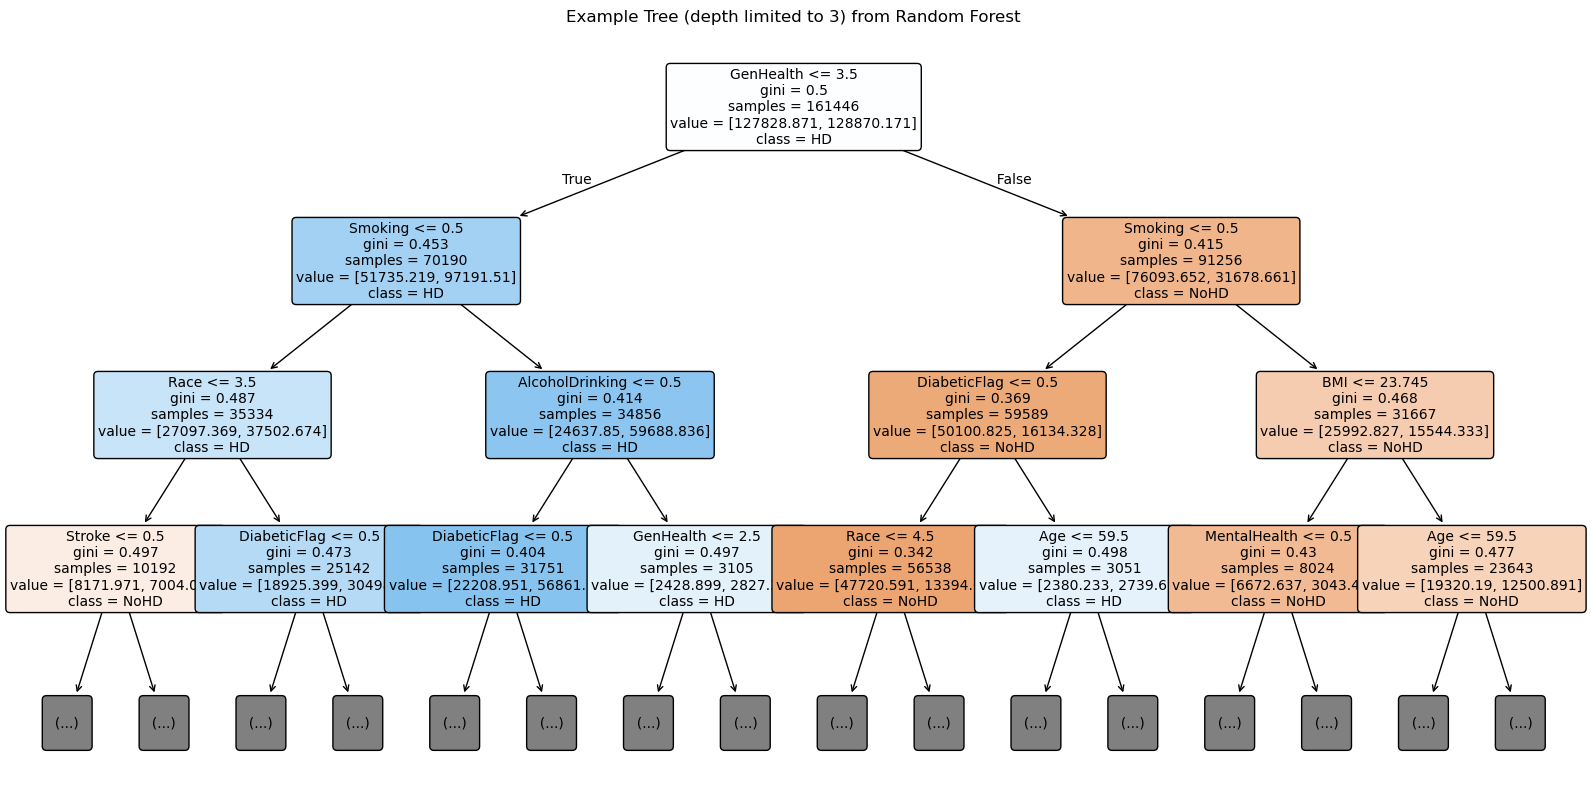

In [27]:
estimator = rf.estimators_[5]
plt.figure(figsize=(20, 10))
tree.plot_tree(
    estimator,
    feature_names=feature_cols,
    class_names=['NoHD', 'HD'],
    max_depth=3,            
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Example Tree (depth limited to 3) from Random Forest")
plt.show()

## Predictive Analysis using LightGBM

Our previous precision, recall, and F1 scores seem quite skewed between individuals with heart disease compared to those without. Therefore, we decided to explore different model options, such as LightGBM, and downsampling both classes to the same size to create a balanced dataset to improve the variation between these values. Optuna was also applied for hyperparameter tuning to balance precision and recall. The model was trained and evaluated through stratified K-Fold cross-validation, which preserves the class distribution. Early stopping was also incorporated during training to prevent overfitting.

In [37]:
# balancing the dataset
features = [
    'Age', 'BMI', 'Smoking', 'AlcoholDrinking', 'PhysicalHealth',
    'MentalHealth', 'DiabeticFlag', 'PhysicalActivity', 'GenHealth',
    'SleepTime', 'Asthma', 'Stroke', 'Sex', 'Race'
]

min_count = df['HeartDisease'].value_counts().min()
df_0 = df[df['HeartDisease'] == 0].sample(min_count, random_state=42)
df_1 = df[df['HeartDisease'] == 1].sample(min_count, random_state=42)
df_balanced = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[features]
y = df_balanced['HeartDisease']

optuna.logging.set_verbosity(optuna.logging.WARNING)

# hyperparameter tuning
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'random_state': 42
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1s = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                early_stopping(30, verbose=False)
            ]
        )
        preds = model.predict(X_val)
        f1s.append(f1_score(y_val, preds))

    return np.mean(f1s)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("\nBest params:", study.best_params)

# train final model with k-fold and optimized threshold
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42
})

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_true = []
thresholds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            early_stopping(30, verbose=False)
        ]
    )

    y_probs = model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_thresh = thresh[np.argmax(f1_scores)]
    thresholds.append(best_thresh)

    y_pred_adj = (y_probs >= best_thresh).astype(int)
    all_preds.extend(y_pred_adj)
    all_true.extend(y_val)

avg_thresh = np.mean(thresholds)
print(f"\nAverage Best Threshold: {avg_thresh:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(all_true, all_preds))


Best params: {'learning_rate': 0.0478299370147675, 'num_leaves': 30, 'feature_fraction': 0.9030425775820197, 'bagging_fraction': 0.8747336750467898, 'bagging_freq': 8, 'min_child_samples': 47}

Average Best Threshold: 0.395

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.64      0.73     27373
           1       0.71      0.88      0.78     27373

    accuracy                           0.76     54746
   macro avg       0.77      0.76      0.76     54746
weighted avg       0.77      0.76      0.76     54746



Here, we can observe that this final model showed a more balanced outcome in terms of precision, recall, and F1-scores between both classes. For class 0, we see that it was correct 84% of the time but has a lower recall value, missing true negatives. As for class 1, we see that the precision and recall are quite high, proving that the model is strong at identifying true heart disease cases.

## Applying the Predictive Model to Identify High-Risk Individuals


After choosing this model as our final one and training it, we are applying it to the set of individuals who do not have heart disease. We intend to identify people in this group who have a high risk of heart disease based on the features from the dataset. By running the model's predictions on this set of people, we can find those who have a high risk for heart disease by establishing a threshold.


In [61]:
df_all_negative = df[df['HeartDisease'] == 0]

# extract features
X_all_negative = df_all_negative[features]

# one-hot encoding
X_all_negative = pd.get_dummies(X_all_negative)
X_model_cols = pd.get_dummies(df_balanced[features]).columns
X_all_negative = X_all_negative.reindex(columns=X_model_cols, fill_value=0)

# retrain model on balanced data
X = pd.get_dummies(df_balanced[features])
y = df_balanced['HeartDisease']
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)

# predict probabilities for negative group
y_probs_all_neg = final_model.predict_proba(X_all_negative)[:, 1]

# find high risk patients
high_risk_indices = y_probs_all_neg >= avg_thresh
df_risk = df_all_negative.iloc[high_risk_indices]
df_risk['PredictedRisk'] = y_probs_all_neg[high_risk_indices]
df_confident = df_risk[df_risk['PredictedRisk'] > 0.8]
df_confident = df_confident.sort_values(by='PredictedRisk', ascending=False)

print(f"Found {len(df_confident):,} people with predicted risk > 0.8.")
df_confident.head()

Found 10,185 people with predicted risk > 0.8.


/tmp/ipykernel_10686/2918924818.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk['PredictedRisk'] = y_probs_all_neg[high_risk_indices]


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,Sex,Race,Diabetic,PhysicalActivity,SleepTime,Asthma,Age,GenHealth,Diabetic_Simple,HD_Simple,DiabeticFlag,PredictedRisk
139613,0,24.09,1,0,1,30.0,20.0,Female,White,Yes,1,2.0,1,57.0,1,DM+,HD-,1,0.942928
211070,0,18.94,1,0,1,30.0,20.0,Male,White,Yes,1,5.0,1,62.0,1,DM+,HD-,1,0.941158
248671,0,15.00,1,0,1,30.0,30.0,Male,White,Yes,1,4.0,1,57.0,1,DM+,HD-,1,0.938534
268003,0,41.60,1,0,1,30.0,30.0,Female,Other,Yes,0,2.0,1,57.0,1,DM+,HD-,1,0.938241
141725,0,17.01,1,0,1,29.0,0.0,Female,Other,Yes,0,8.0,1,67.0,2,DM+,HD-,1,0.937502


The above shows that 10,000 individuals have a predicted risk for heart disease that is greater than 0.8. This was concluded by combining all the factors above to classify these datapoints. For example, the first row shows that this individual has a higher BMI, has smoked, has had a stroke, and is diabetic, which contributes to this predicted risk. This can help identify those who need to incorporate preventative measures and improve early heart disease detection.

## Stratified Modeling on Diabetic and Non-Diabetic Groups
Now that we've created predictive models, trained and tested them to predict heart disease, and employed them in identifying high-risk individuals, let's revisit our first research question to compare the model's behaviour with 2 different groups. We splits the dataset into 2 groups: people who have diabetes and who don't. Here is the research question as a reminder!

**Does the predictive power of traditional risk factors (e.g., BMI, BP, cholesterol) differ between patients with and without diabetes?**


In [39]:
# to avoid any NaNs or any mistakes when separating Diabetics and Non-Diabetics, we will just re-load and clean our dataset
df = pd.read_csv('data/heart_2020_cleaned.csv')

df['HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})
df['Diabetic']     = df['Diabetic'].map({'Yes': 1, 'No': 0})

df_enc = pd.get_dummies(df.drop(columns=['Diabetic']), drop_first=True)
df_enc['Diabetic'] = df['Diabetic']

df_diab  = df_enc[df_enc['Diabetic']==1].drop(columns=['Diabetic'])
df_nondi = df_enc[df_enc['Diabetic']==0].drop(columns=['Diabetic'])

print("Diabetic group size:", len(df_diab))
print("Non-Diabetic group size:", len(df_nondi))

Diabetic group size: 40802
Non-Diabetic group size: 269653


Here we split the dataframe into two groups, diabetic and non-diabetic, to perform stratified modeling. We will then train and evaluate models separately on each group and compare their predictive powers.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def run_models(df_group, group_name):
    X = df_group.drop(columns='HeartDisease')
    y = df_group['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    results = []
    
    # logistic regression only
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_s, y_train)
    p_lr = lr.predict_proba(X_test_s)[:,1]
    r_lr = lr.predict(X_test_s)
    results.append({
        "Model":"LogisticRegression", "Group":group_name,
        "AUC":roc_auc_score(y_test, p_lr),
        "F1":f1_score(y_test, r_lr),
        "Accuracy":accuracy_score(y_test, r_lr)
    })
    
    # decision tree
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_train, y_train)
    p_dt = dt.predict_proba(X_test)[:,1]
    r_dt = dt.predict(X_test)
    results.append({
        "Model":"DecisionTree", "Group":group_name,
        "AUC":roc_auc_score(y_test, p_dt),
        "F1":f1_score(y_test, r_dt),
        "Accuracy":accuracy_score(y_test, r_dt)
    })
    
    # random forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    p_rf = rf.predict_proba(X_test)[:,1]
    r_rf = rf.predict(X_test)
    results.append({
        "Model":"RandomForest", "Group":group_name,
        "AUC":roc_auc_score(y_test, p_rf),
        "F1":f1_score(y_test, r_rf),
        "Accuracy":accuracy_score(y_test, r_rf)
    })
    
    return pd.DataFrame(results), rf, X_test

In [41]:
res_diab,  rf_diab,  X_test_diab  = run_models(df_diab,  "Diabetic")
res_nondi, rf_nondi, X_test_nondi = run_models(df_nondi, "Non-Diabetic")

all_results = pd.concat([res_diab, res_nondi], ignore_index=True)
all_results.style.format({"AUC":"{:.3f}", "F1":"{:.3f}", "Accuracy":"{:.3f}"})

,Model,Group,AUC,F1,Accuracy
0,LogisticRegression,Diabetic,0.755,0.293,0.791
1,DecisionTree,Diabetic,0.699,0.232,0.784
2,RandomForest,Diabetic,0.703,0.290,0.769
3,LogisticRegression,Non-Diabetic,0.833,0.108,0.935
4,DecisionTree,Non-Diabetic,0.742,0.038,0.935
5,RandomForest,Non-Diabetic,0.768,0.113,0.923


Based on the results, the Logistic Regression model performed best overall for the diabetic group, achieving the highest AUC score. For the non-diabetic group, all three models had relatively high accuracy scores of around 93%, but their F1 scores were much lower. This could be due to a lack of representation of positive heart disease cases among non-diabetic individuals, leading to class imbalance. Interestingly, the AUC scores for the non-diabetic group were higher than those for the diabetic group, suggesting that the models were better at ranking predictions in the non-diabetic group, but struggled to actually identify true positives.

/tmp/ipykernel_10686/138413187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette=colors)


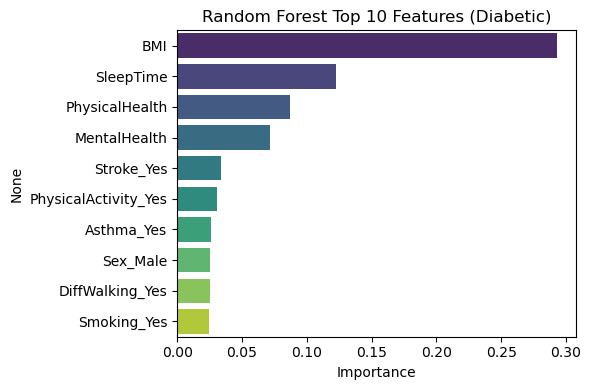

/tmp/ipykernel_10686/138413187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette=colors)


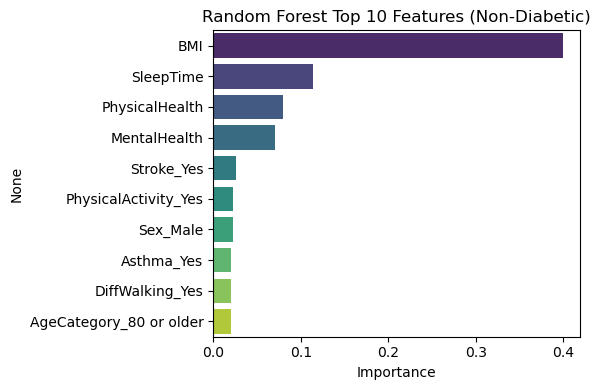

In [43]:
def plot_top10(rf_model, X_test, title):
    imp = pd.Series(rf_model.feature_importances_, index=X_test.columns)
    top10 = imp.sort_values(ascending=False).head(10)
    plt.figure(figsize=(6,4))
    colors = sns.color_palette("viridis", len(top10))
    sns.barplot(x=top10.values, y=top10.index, palette=colors)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_top10(rf_diab,  X_test_diab,  "Random Forest Top 10 Features (Diabetic)")
plot_top10(rf_nondi, X_test_nondi, "Random Forest Top 10 Features (Non-Diabetic)")

From our Random Forest model, we can see that for both diabetic and non-diabetic groups, BMI is the most important feature for predicting heart disease—though it appears to be even more influential in the non-diabetic group. The importance scores shown range from 0 to 0.4, where higher values indicate greater influence on the model’s decision-making. These plots display the top 10 features with the highest relevance in predicting heart disease within each group. Other key features like SleepTime, PhysicalHealth, and MentalHealth are important in both groups, suggesting they are consistently useful predictors regardless of diabetic status. Meanwhile, Smoking and Sex appear more relevant in the diabetic group, and AgeCategory_80 or oldershows up only in the non-diabetic group. This suggests that while the same types of features are important, their relative influence may differ depending on whether a person is diabetic or not.

# Ethics & Privacy

The “Personal Key Indicators of Heart Disease (2020)” dataset used in our analysis, sourced from the CDC’s Behavioral Risk Factor Surveillance System (BRFSS) and cleaned by Kamil Pytlak, raises several ethical and privacy-related considerations. 

From an equity standpoint, there are three relevant bias vectors. (1) Sampling bias: BRFSS relies on landline/cell calls conducted only in English and Spanish, so people without stable phone access, those living in institutions, and speakers of other languages are under-sampled; rural and low-income respondents also have higher non-response rates. (2) Measurement bias: all variables, including the heart-disease and diabetes flags, are self-reported, which can lead to systematic under- or over-reporting that varies by culture, age, and insurance status. Accounting for bias in reporting is likely beyond the scope of this class. (3) Pre-processing bias: the Kaggle version drops “Don’t know/Refused” answers and collapses several race and health-status categories, potentially obscuring small but vulnerable sub-populations. 

Consequently, analyses conducted with this dataset may underrepresent marginalized groups, potentially resulting in findings that fail to generalize equitably across different demographics. To mitigate this, we will critically assess the representativeness of our sample relative to the broader U.S. population by comparing demographic distributions within our dataset to U.S. Census data and BRFSS documentation, explicitly reporting these biases when communicating our results.

In terms of privacy, the BRFSS is a federal public-domain resource, so there are no licensing barriers as long as we credit the CDC and the Kaggle author likewise permits reuse under the site’s open-data terms. The file is already fully de-identified (no direct or quasi-identifiers), so re-identification risk is low, but we will avoid merging it with any additional dataset that could undo that anonymity. Given the scale of this dataset, we should not need another.

Finally, acknowledging that this dataset inherently captures existing societal and healthcare inequities (e.g., disparities in healthcare access and preventive measures), our analyses must be presented contextually. We commit to transparently discussing how socioeconomic, racial, and other demographic factors influence the predictive power of heart disease indicators, in regard to diabetes. By employing sensitivity analyses and carefully examining model performance across demographic groups, we will strive to ensure our findings do not inadvertently perpetuate existing biases or inequities, but rather highlight areas for equitable public health intervention.

Potential methods for addressing these issues:
To surface these issues we will (a) compare the weighted demographic marginals to 2020 Census distributions, (b) run missing-data diagnostics and sensitivity analyses that re-introduce excluded responses, and (c) compute fairness metrics (e.g., subgroup-specific false-positive rates) whenever we fit predictive models.

If we find material disparities, we will document them in the results, replicate key analyses with BRFSS-supplied survey weights, and, where appropriate, add stratified models or re-weighting to mitigate skew. All code and summary tables will be published so that other researchers can audit our decisions, and our write-up will caution against deploying any model for individual clinical decision-making without further validation on representative clinical data.

# Discussion and Conclusion

We see from the above report that while the model has great precision and recall for people who don't have heart disease, it doesn't perform nearly as well when predicting people who do have heart disease. When screening for diseases, we prioritize detecting true positives and weigh the false negative errors as more concerning, since heart diseases can have fatal impacts when they are not detected in time. Let's try to improve this DecisionTreeClassifier with a RandomForestClassifier, which computes many trees and has them vote on a prediction!


Throughout the course of this project, we investigated the relationship between diabetes status and the predictive power of traditional cardiovascular risk factors for heart disease, using the 2020 CDC Behavioral Risk Factor Surveillance System (BRFSS) dataset. Our two salient aims were to evaluate whether the predictive powers of common risk factors differ between diabetic and non-diabetic individuals, and to apply our predictive models to identify "high-risk but undiagnosed" individuals within the non-heart-disease population who would benefit from early detection.


Our exploratory data analysis (with data distributions and visualizations like correlation matrices, heatmaps, boxplots etc.) as well as inferential analysis (logistic regression, Poisson etc.) confirm that diabetes is a significant independent risk factor for heart disease, with diabetic individuals facing 56–79% higher risk. Both logistic regression and modified Poisson models were aligned in showing this high risk, and checks like multicollinearity diagnostics, sex-stratified models, and outlier diagnostics demonstrated that this association is highly robust.


Following this initial analysis, we trained several machine learning classifiers (Decision Tree, Random Forest, and LightGBM), amplifying model performance and improving predictions. Although the baseline model- Decision Tree Classifier- struggled to detect the presence of heart disease in class 1 (with a recall of 22%), the Random Forest dramatically improved recall for the positive class (81%), which is our priority in disease screening, where identifying true cases is critical. The final LightGBM model, optimized via Optuna hyperparameter tuning and trained on a dataset balanced by undersampling, produced even more balanced performance across both classes (we achieved a macro F1-score of 78%).


Applying our best model to the population without a reported history of heart disease identified over 17,000 individuals with a predicted risk greater than 0.8. Many of these high-risk individuals share similar characteristics of advanced age, elevated BMI, diabetes, and poor physical health, identifiers that match clinical expectations for those at higher cardiovascular risk.


We then revisited our first aim of comparing model performance by splitting the dataset into diabetic and non-diabetic subgroups, and found interesting differences in model behavior. While AUCs were higher for non-diabetics, likely due to more distinct separation between diseased and non-diseased cases, the models' ability to identify true positives (as reflected in F1 scores) remained stronger for diabetics, where heart disease prevalence is higher. Feature importance analyses revealed that while certain predictors (e.g. BMI, PhysicalHealth, MentalHealth, SleepTime) were similarly important across both groups, factors such as Smoking and Sex held more predictive weight among diabetics, but advanced age was a stronger discriminator among non-diabetics.


In conclusion, our data analysis and development of predictive models not only show the insights we gleaned from data used for a practical purpose but also show the importance of machine learning models for risk stratification. The consistently high feature importance of age, general health, BMI, and diabetes status highlights steps that we can take for preventative care. Additionally, identifying high-risk but undiagnosed individuals can help us devise early intervention strategies that could meaningfully reduce the societal burden of cardiovascular disease. Thank you!



# Team Contributions

- __Andrew Gibson:__ Background Research: Scientific Publications, Descriptive Analysis: BMI Histplot, EDA: Barplots and Heatmaps for Heart Disease and Diabetes for Physical Health and for Mental Health, 2D correlation matrix/heatmap, Inferential Analysis: Logistic Regression, Generalized Linear Regression, ROC Curves, VIF multicollinearity check, Stratified Logistic Regression, Cook's Distance, Interaction Term, Logistic Regression Visualization, Predictive: Random Forest (the first one), Ethics Section
- __Sofia Morales-Fermin:__  Abstract, Background Research: Other Data Science Projects, EDA: HealthyLifestyle by HD/DM bar chart and 2D Correlation Heatmap with all variables, wrote caption for Model Option 1: RandomForestClassifier, Ad Nauseam: Chi Square Heat Map, Cramer's V, wrote caption for Random Forest Feature Importances.
- __Samantha Lincoln:__ Ethics and Privacy, Research Question, Data cleaning for GenHealth, Team Expectations, EDA:  HD with and without diabetes compared to Strokes Heatmap, Stratified modeling for diabetic and non-diabetic individuals, Ad Nauseam: HD with and without diabetes compared to GenHeatlh Boxplot

- __Nayana Naineni:__ Descriptive Analysis: Boxplot of BMI between diabetics and non-diabetics, Heat map of diabetics and non-diabetics, and asthma and no asthma. Summary statistics for Heart Disease and Diabetes, interpretation of distribution. Predictive Analysis: LightGBM model implementation, hyperparameter tuning with Optuna, identification of high-risk individuals. Final edits: Improved conciseness and shifted redundant information in the Ad Nauseam section.
- __Ananya Wasker:__ Finding datasets, Data Overview, Data Cleaning and Data Pre-Processing, Descriptive Analysis, Data Visualizations: Boxplots on Age Distributions by Heart Disease and Diabetic Status and Heatmaps on Heart Disease Rates by Race and Sex split by Diabetic Status, Baseline Predictive Model with Decision Tree Classifier, Final Discussion and Conclusion Section, Making and Editing the Video

# Ad Nauseam

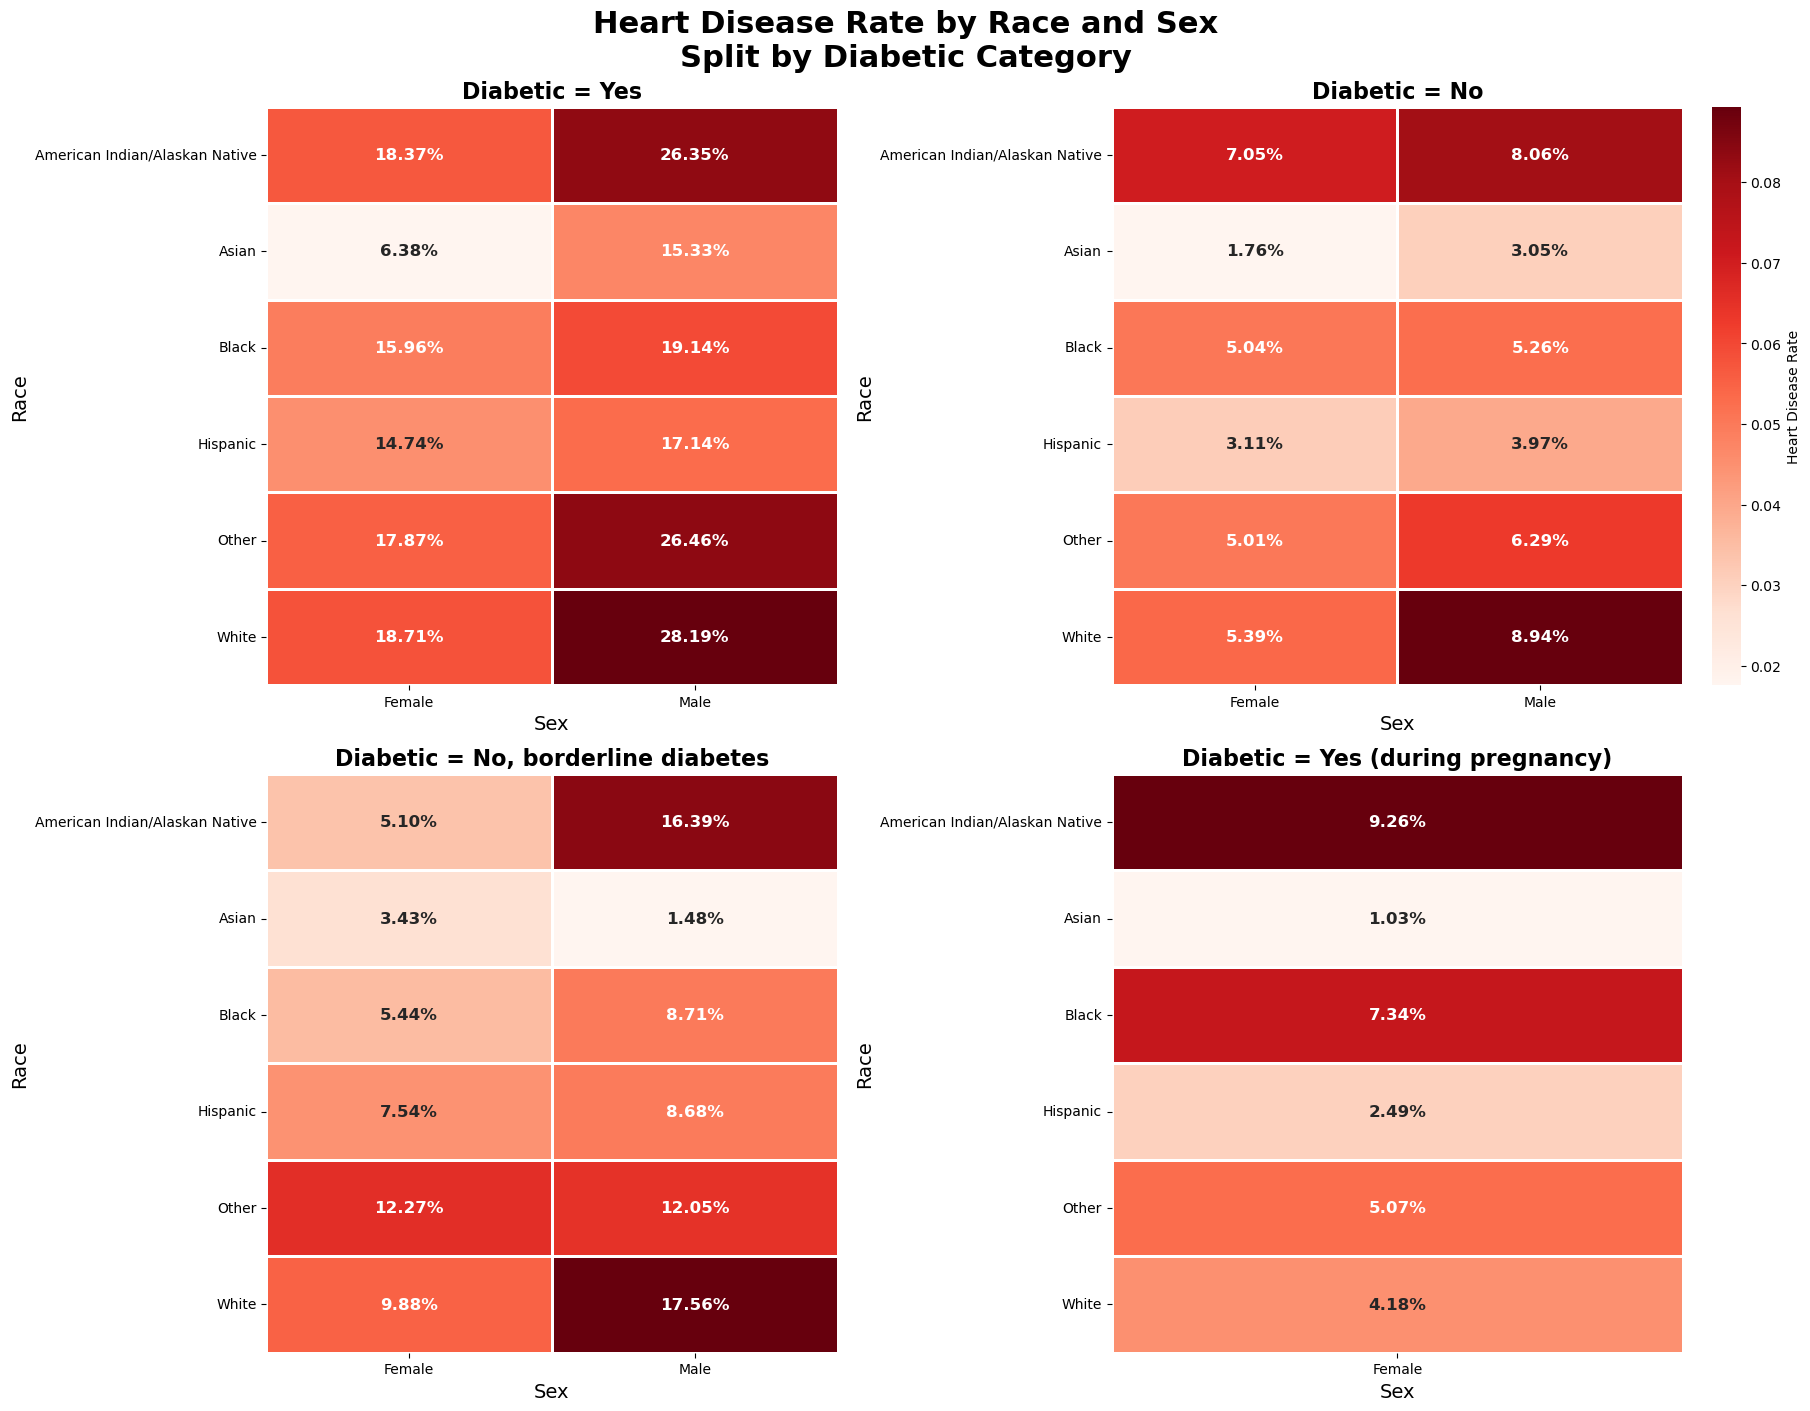

In [44]:
diabetic_groups = heart_disease_dataset['Diabetic'].unique()

fig, axes = plt.subplots(2, 2, figsize=(18, 14), constrained_layout=True)

for ax, group in zip(axes.flat, diabetic_groups):
    subset = heart_disease_dataset[heart_disease_dataset['Diabetic'] == group]
    pivot_data = subset.groupby(['Race', 'Sex'])['HeartDisease'].mean().unstack()
    pivot_data = pivot_data.astype(float)  
    
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".2%",
        cmap="Reds",
        linewidths=0.8,
        linecolor='white',
        cbar=ax == axes[0, 1], 
        cbar_kws={'label': 'Heart Disease Rate'},
        annot_kws={"size": 12, "weight": "bold"},
        ax=ax
    )
    
    ax.set_title(f"Diabetic = {group}", fontsize=16, weight='bold')
    ax.set_xlabel("Sex", fontsize=14)
    ax.set_ylabel("Race", fontsize=14)
    ax.yaxis.set_tick_params(rotation=0)
    ax.xaxis.set_tick_params(rotation=0)

plt.suptitle("Heart Disease Rate by Race and Sex\nSplit by Diabetic Category", fontsize=22, weight='bold')
plt.show()

From both the plots, we can gain meaningful insights about CDC survey data. From the boxplots we see that the average ages of people who don't and do have heart disease differ drastically in non-diabetic people, while in diabetic people the difference in age between those who do have heart disease and those who don't is relatively smaller. From the heatmaps we see that a staggering 28% of diabetic White men have heart disease history, while only 9% of non-diabetic White men have heart disease history. These maps show us that the correlation strength between race and sex is different across diabetic groups, which will aid us in answering our research question.

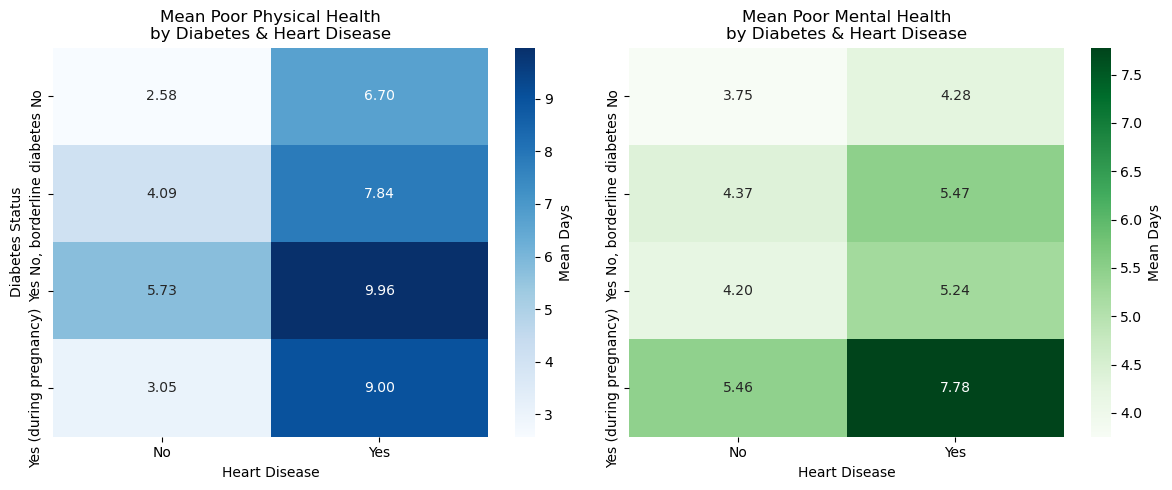

In [ ]:
ph_pivot = heart_disease_dataset.pivot_table(
    index='Diabetic',
    columns='HeartDisease',
    values='PhysicalHealth',
    aggfunc='mean'
).rename(columns={0: 'No', 1: 'Yes'})

mh_pivot = heart_disease_dataset.pivot_table(
    index='Diabetic',
    columns='HeartDisease',
    values='MentalHealth',
    aggfunc='mean'
).rename(columns={0: 'No', 1: 'Yes'})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sns.heatmap(
    ph_pivot,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar_kws={'label': 'Mean Days'},
    ax=axes[0]
)
axes[0].set_title('Mean Poor Physical Health\nby Diabetes & Heart Disease')
axes[0].set_xlabel('Heart Disease')
axes[0].set_ylabel('Diabetes Status')

sns.heatmap(
    mh_pivot,
    annot=True,
    fmt='.2f',
    cmap='Greens',
    cbar_kws={'label': 'Mean Days'},
    ax=axes[1]
)
axes[1].set_title('Mean Poor Mental Health\nby Diabetes & Heart Disease')
axes[1].set_xlabel('Heart Disease')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Across every diabetes group, having heart disease is linked to more days of poor physical health—and that gap grows as you move from non-diabetic to full diabetic status. For physical health, non-diabetics jump from an average of about 2.6 bad days without heart disease to 6.7 with it, borderline cases go from 4.1 to 7.8 days, full diabetics from 5.7 up to 9.96 days, and pregnant diabetics from 3.05 to 9.0 days. In contrast, mental health shows smaller increases: non-diabetics rise from 3.75 to 4.28 bad days, borderline from 4.37 to 5.47, diabetics from 4.20 to 5.24, and pregnant diabetics from 5.46 up to 7.78. In plain terms, heart disease has a much stronger impact on how often people feel physically unwell, especially among diabetics, while its effect on mental distress is more modest.

For this section of the EDA, we will be focusing on the variables BMI and asthma. First, we will create a boxplot with BMI for individuals with and without diabetes as well as with and without heart disease.

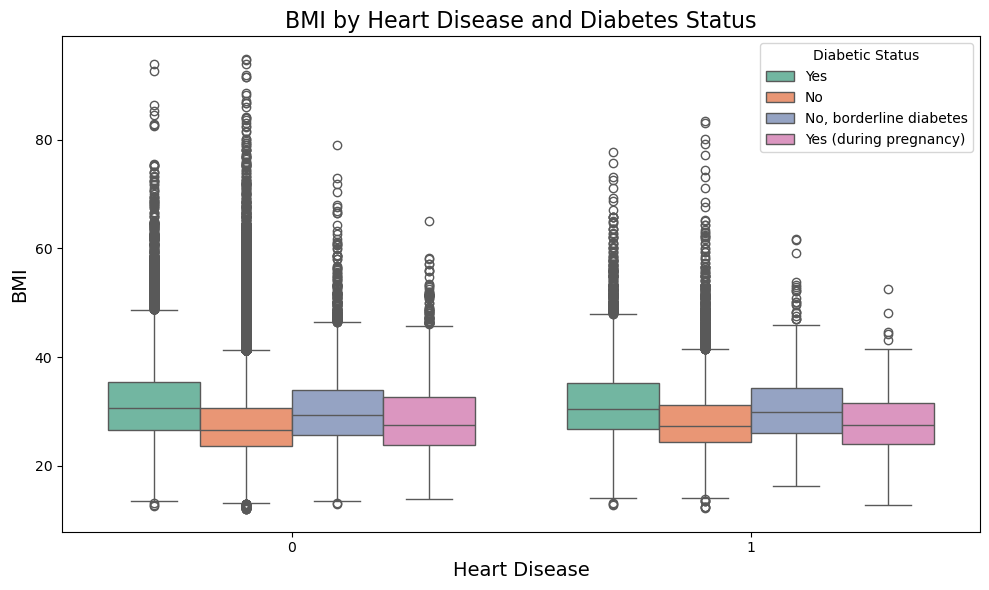

In [46]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=heart_disease_dataset, 
    x='HeartDisease', 
    y='BMI', 
    hue='Diabetic', 
    palette='Set2'
)

plt.legend(loc='upper right', title='Diabetic Status')
plt.title('BMI by Heart Disease and Diabetes Status', fontsize=16)
plt.xlabel('Heart Disease', fontsize=14)
plt.ylabel('BMI', fontsize=14)
plt.tight_layout()
plt.show()

Now, we will explore the variable asthma. Below is a heat map depicting the proportions of individuals with and without heart disease, with and without diabetes, and with and without asthma.

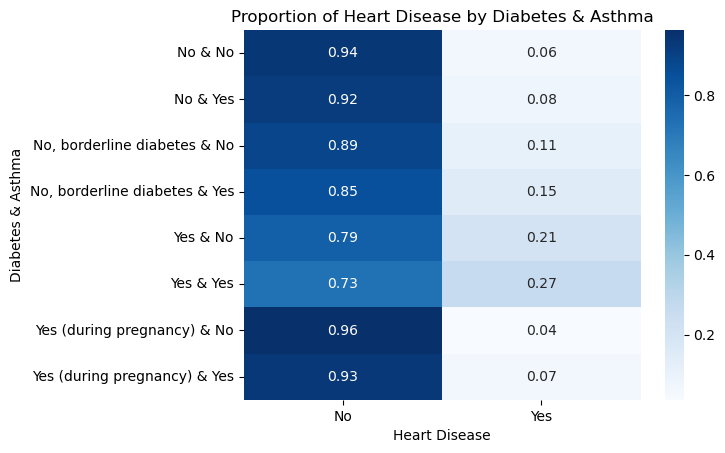

In [48]:
combo_label = heart_disease_dataset['Diabetic'].astype(str) + ' & ' + \
              heart_disease_dataset['Asthma'].map({0: 'No', 1: 'Yes'}).astype(str)

crosstab = pd.crosstab(combo_label, heart_disease_dataset['HeartDisease'].map({0: 'No', 1: 'Yes'}))

proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

sns.heatmap(proportions, annot=True, cmap='Blues', fmt='.2f')
plt.title("Proportion of Heart Disease by Diabetes & Asthma")
plt.ylabel("Diabetes & Asthma")
plt.xlabel("Heart Disease")
plt.show()

This heat map shows the proportion of individuals with and without heart disease within each group for diabetes status and asthma status. Each row adds up to 1 and represents all the possible combinations. Here, we can observe that individuals who have asthma and don't have diabetes but have heart disease (8%) are higher than individuals without asthma, which indicates that asthma slightly contributes to heart disease risk. Then, for the row with borderline diabetes and no asthma, we see that this value (11%) is much higher than the previous one, implying that being pre-diabetic is a much higher risk factor for heart disease as compared to asthma independently. As we go down the map, we can see that combining both borderline diabetes and asthma increases the risk further, and diabetes and asthma are even higher than that. As for gestational diabetes, we see that the risk for heart disease is quite low (4% without asthma and 7% with). This shows that gestational diabetes, most likely due to its temporary nature, is not a strong predictor of heart disease. Overall, the heatmap shows that diabetes is a very strong risk factor for heart disease and asthma further increases this risk.

/tmp/ipykernel_10686/2502926155.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(


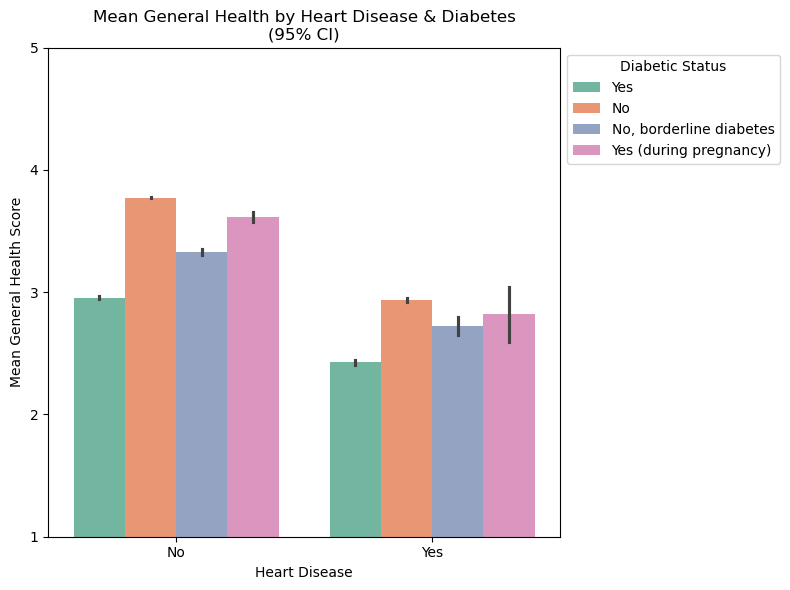

In [49]:
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=heart_disease_dataset,
    x='HeartDisease',
    y='GenHealth',
    hue='Diabetic',
    ci=95,
    palette='Set2'
)

plt.ylim(1, 5)
plt.yticks([1,2,3,4,5])

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])

plt.xlabel("Heart Disease")
plt.ylabel("Mean General Health Score")
plt.title("Mean General Health by Heart Disease & Diabetes\n(95% CI)")
plt.legend(title="Diabetic Status", loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Here, from the boxplot and the descriptive information from the dataset, we can see that on average, individuals with both diabetes and heart disease had the highest BMI (mean = 31.74), compared to those with no diabetes or heart disease (mean = 27.72). Surprisingly enough, people with heart disease without diabetes had a lower mean BMI (28.23) than diabetic individuals without heart disease (30.41–30.75). This could mean that having a higher BMI might increase heart disease risk more in people with diabetes than in individuals without diabetes. Those who had diabetes during pregnancy generally had lower BMIs with heart disease and without heart disease, proving that other factors may be at play. Additionally, while looking at both diabetic as well as non-diabetic people, we can observe that the average BMI of those with heart disease is higher than those without. This is similarly shown with individuals with and without heart disease, whilst looking at diabetic compared to non-diabetic people. This makes sense scientifically, as high BMI is known to have a relationship with both diabetes and heart disease independently. These results suggest that BMI's relationship with heart disease is dependent on diabetes status, as individuals with heart disease often tend to have higher BMI values, and this impact is intensified in those with diabetes. Therefore, both diabetes and heart disease prove to share underlying risk factors related to obesity.

In the bar plot, we compare average self-rated health (on a 1–5 scale) between people with (“Yes”) and without (“No”) heart disease, subdivided by their four diabetes categories. Those without heart disease consistently report mean scores close to 3.8–4.0, indicating “Good” to “Very good” health, while all heart-disease groups drop down to roughly 2.5–3.0, reflecting “Fair” to “Good” health. The confidence intervals for the HD– and HD+ bars do not overlap, showing that the difference in perceived health between these two populations is unlikely to be due to chance. Diabetes status shifts each cluster slightly—non-diabetics without heart disease sit highest, and “Yes (during pregnancy)” tends toward the top of each set—but the dominant effect is the presence versus absence of heart disease.

In [50]:
df = heart_disease_dataset.copy()
yes_no_cols = ["HeartDisease", "Diabetic",
               "Smoking", "AlcoholDrinking", "PhysicalActivity"]
normaliser = {"yes": "Yes", "y": "Yes", "1": "Yes", "true": "Yes", True: "Yes",
              "no": "No",  "n": "No",  "0": "No",  "false": "No",  False: "No"}
for col in yes_no_cols:
    df[col] = (
        df[col]                    
          .astype(str)           
          .str.strip()          
          .str.lower()          
          .map(normaliser)
    )
df["HealthyLifestyle"] = (
    (df["Smoking"]          == "No") &
    (df["AlcoholDrinking"]  == "No") &
    (df["PhysicalActivity"] == "Yes")
).astype(int)
hd_map = {"No": "No HD",  "Yes": "Has HD"}
dm_map = {"No": "No DM",  "Yes": "Has DM"}
df["HD_DM_Group"] = (
    df["HeartDisease"].map(hd_map) + "/" +
    df["Diabetic"].map(dm_map)
)
hl_summary = (
    df.groupby("HD_DM_Group")["HealthyLifestyle"]
      .value_counts(normalize=True) 
      .rename("proportion")  
      .reset_index() )
hl_pivot = (hl_summary
            .pivot(index="HD_DM_Group",
                   columns="HealthyLifestyle",
                   values="proportion")
            .fillna(0)
            .rename(columns={0: "Unhealthy (0)", 1: "Healthy (1)"}))
hl_pivot

HealthyLifestyle,Unhealthy (0),Healthy (1)
HD_DM_Group,,
Has HD/Has DM,0.774478,0.225522
Has HD/No DM,0.700382,0.299618
No HD/Has DM,0.645062,0.354938
No HD/No DM,0.515052,0.484948


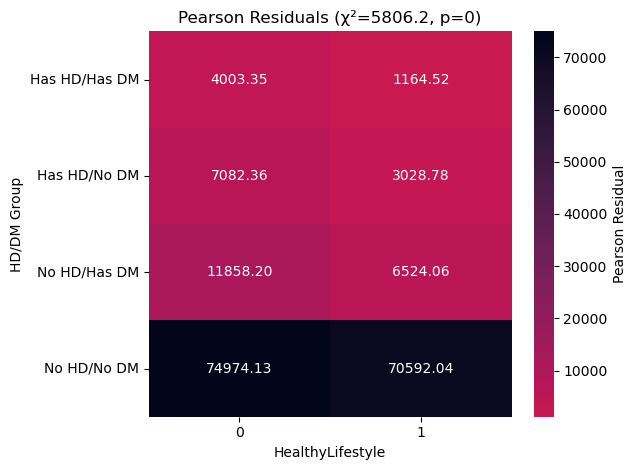

In [51]:
ct = pd.crosstab(df["HD_DM_Group"], df["HealthyLifestyle"])
chi2, p, expected, _ = stats.chi2_contingency(ct)
residuals = (ct - expected) / np.sqrt(expected)
sns.heatmap(
    residuals,
    annot=True,
    cmap="rocket_r",
    center=0,
    fmt=".2f",
    cbar_kws={"label": "Pearson Residual"}
)
plt.ylabel("HD/DM Group")
plt.xlabel("HealthyLifestyle")
plt.title(f"Pearson Residuals (χ²={chi2:.1f}, p={p:.2g})")
plt.tight_layout()
plt.show()

In [52]:
ct = pd.crosstab(df["HD_DM_Group"], df["HealthyLifestyle"])

chi2, p, dof, expected = chi2_contingency(ct)
n     = ct.values.sum()
phi2  = chi2 / n
r, k  = ct.shape
cramer_v = np.sqrt(phi2 / (min(k - 1, r - 1)))

print(f"Cramér's V = {cramer_v:.3f}")

Cramér's V = 0.137


A Cramér’s V of 0.137 corresponds to small but non-negligible value, indicating that the HD/DM status and HealthyLifestyle flag are related, but the relationship is not strong at all. If we square V, we get that $V^2$ ≈ 0.019, meaning that about 1.9% of the variability in lifestyle, which is statistically significant but is only a small part of the overall picture. 

Cardiometabolic conditions do seem to have an influence towards unhealthy habits, but it is evident that most of the behavioural difference must be driven by other factors, such as BMI, demographics, or other variables. Consequently, HD and DM alone are weak predictors and any model should include stronger covariates.

Now that we're explored several different sets of specific variables, we can use a correlation matrix to map every variable against each other. Of course this only gives us two dimensions, but it's a good starting point to identify the most important risk factors associated with heart disease.

This plot describes the overall χ² = 5,806.2 indicating a very small p-value (p <<< 0.0001), into cell-by-cell contributions. The deeper shades correspond to cells that drive the rejection of the null hypothesis of independence. The numbers in each tile represent the exact Pearson contribution for that cell. All cells overshoot the independence of expectation since every observed count exceeds the expected count. This happens when both margins are highly unbalanced, where HealthyLifestyle = 0 and Has HD / Has DM and No HD / No DM dominate the dataset. Moreover, the χ² is driven by the population with no HD and no DM, since they account for 75% of the total χ². Any statistical significance largely reflects the lifestyle variations among people without both HD and DM. Finally, the last takeaway from this heat map is that this data should be interpreted with proportions and not residuals since the Pearson contributions increase with cell size. This means that complementary plots better visualize the substantive effect of the monotonic rise in healthy-lifestyle prevalence as the cardiometabolic burden decreases.


In [53]:
df = heart_disease_dataset.copy()

df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

df['HeartDisease'] = df['HeartDisease'].astype(int)

formula = 'HeartDisease ~ DiabeticFlag + Age + BMI + Smoking + PhysicalActivity + GenHealth'

poisson_mod = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.Poisson()
).fit(cov_type='HC3')

print(poisson_mod.summary())

params = poisson_mod.params
conf = poisson_mod.conf_int()
rr_df = pd.DataFrame({
    'RR': np.exp(params),
    'CI Lower': np.exp(conf[0]),
    'CI Upper': np.exp(conf[1])
})
print("\nRisk Ratios with 95% CI:")
print(rr_df)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                            GLM   Df Residuals:                   319788
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79066.
Date:                Wed, 11 Jun 2025   Deviance:                   1.0339e+05
Time:                        20:05:08   Pearson chi2:                 2.57e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09292
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.3674      0.048  

The modified Poisson model confirms that diabetes remains a significant, independent risk factor: persons with diabetes have a roughly 56% higher risk of heart disease (RR ≈ 1.56) even after adjustment—somewhat attenuated compared to the 79% higher odds from the logistic model but still clearly elevated. All other covariate effects remain directionally consistent (e.g., each year of age raises risk, smoking increases risk, and better general health is protective), and physical activity now achieves borderline statistical significance (RR ≈ 1.03), suggesting its modest impact is more detectable when modeling risk ratios instead of odds.

AUC without DiabeticFlag: 0.817
AUC with DiabeticFlag:    0.821


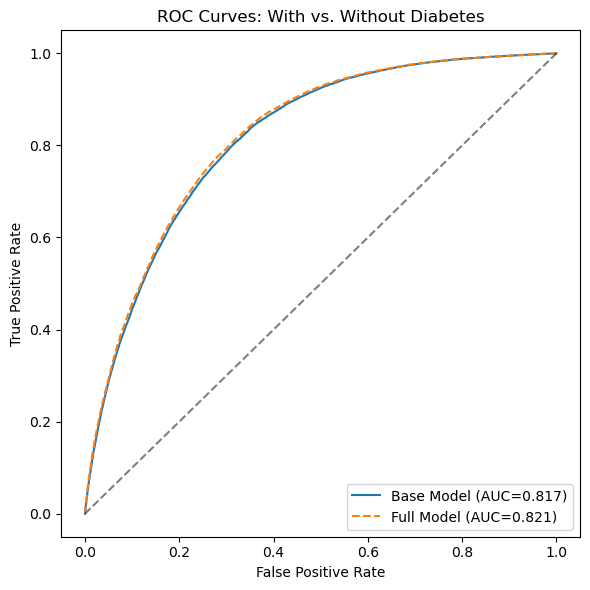

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve

df = heart_disease_dataset.copy()

df['HeartDisease'] = df['HeartDisease'].astype(int)             # making binaries numeric
df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

formula_base = 'HeartDisease ~ Age + BMI + Smoking + PhysicalActivity + GenHealth'
model_base = smf.logit(formula_base, data=df).fit(disp=False)
df['pred_base'] = model_base.predict(df)

formula_full = 'HeartDisease ~ DiabeticFlag + Age + BMI + Smoking + PhysicalActivity + GenHealth'
model_full = smf.logit(formula_full, data=df).fit(disp=False)
df['pred_full'] = model_full.predict(df)

auc_base = roc_auc_score(df['HeartDisease'], df['pred_base'])
auc_full = roc_auc_score(df['HeartDisease'], df['pred_full'])
print(f"AUC without DiabeticFlag: {auc_base:.3f}")
print(f"AUC with DiabeticFlag:    {auc_full:.3f}")

fpr_base, tpr_base, _ = roc_curve(df['HeartDisease'], df['pred_base'])
fpr_full, tpr_full, _ = roc_curve(df['HeartDisease'], df['pred_full'])

plt.figure(figsize=(6, 6))
plt.plot(fpr_base, tpr_base, label=f'Base Model (AUC={auc_base:.3f})')
plt.plot(fpr_full, tpr_full, label=f'Full Model (AUC={auc_full:.3f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: With vs. Without Diabetes')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

The AUC increased from 0.817 in the base model to 0.821 when diabetes status was added, indicating a modest but meaningful improvement in discrimination. In other words, including ``` DiabeticFlag ``` slightly enhances the model’s ability to distinguish between those with and without heart disease.


In [55]:
df = heart_disease_dataset.copy()

if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

df['HeartDisease'] = df['HeartDisease'].astype(int)

formula_gen = 'HeartDisease ~ DiabeticFlag * GenHealth + Age + BMI + Smoking + PhysicalActivity'
model_gen = smf.logit(formula_gen, data=df).fit(disp=False)

print("Logistic Regression with DiabeticFlag × GenHealth Interaction\n")
print(model_gen.summary())

formula_phys = 'HeartDisease ~ DiabeticFlag * PhysicalHealth + Age + BMI + Smoking + PhysicalActivity + GenHealth'
model_phys = smf.logit(formula_phys, data=df).fit(disp=False)

print("\nLogistic Regression with DiabeticFlag × PhysicalHealth Interaction\n")
print(model_phys.summary())

Logistic Regression with DiabeticFlag × GenHealth Interaction

                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319787
Method:                           MLE   Df Model:                            7
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.1913
Time:                        20:05:54   Log-Likelihood:                -75575.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.3441      0.060    -71.957      0.000      -4.462      -4.226
DiabeticFlag               0.334

__Feature Importance Plot__

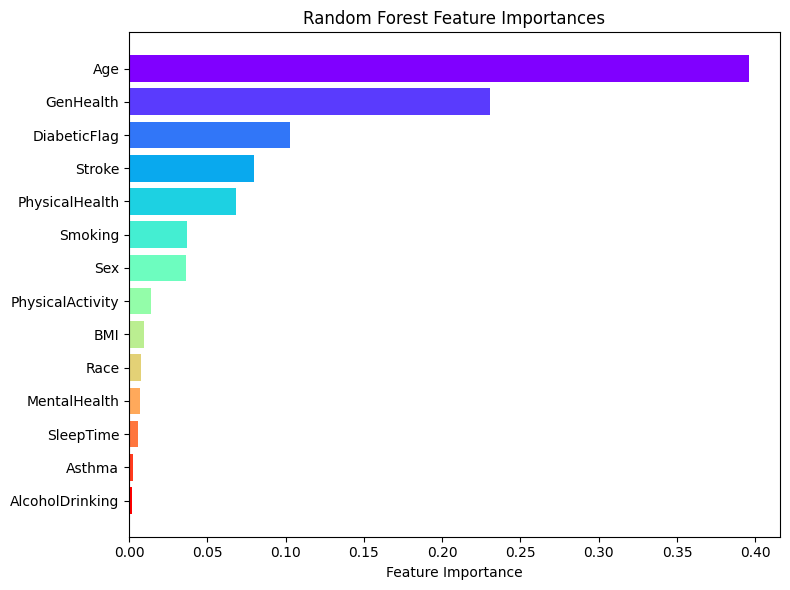

In [41]:
from sklearn import tree
from matplotlib import cm

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

n_feats = len(indices)
colors = cm.rainbow(np.linspace(0, 1, n_feats))

plt.figure(figsize=(8, 6))
plt.barh(
    [feature_cols[i] for i in indices],
    importances[indices],
    color=colors
)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

estimator = rf.estimators_[5]


The bar chart above shows Age as the single most important predictor of HD, with about 44% of the total importance weight, which suggests that age alone split's many of the tree's nodes. GenHealth is the second greatest predictor, at around 30%, which indicates that self-related health captures are a large chunk of variability if someone has HD or not. The next two parameters with the greatest feature importance are DiabeticFlag, PhysicalHealth, and Sex which confirms the fact that being diabetic and reporting more days of poor physical health are substantial risk factors of HD. The rest of the parameters, (BMI, Race, SleepTime, MentalHealth, Stroke, Asthma, PhysicalActivity, AlcoholDrinking, Smoking) have a less significant feature importance. Moreover, the feature-importance plot underscores that age, general health, and diabetic status dominate the model's ability to distinguish HD cases from non-HD cases.

In [ ]:
"""
WARNING!!!

The following code is commented out because it took Andy ~120mins to run on his computer (MacBook Pro 14in, Intel Pro Chip 2024).

That being said the precision, recall, and f1 scores are better cool :)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, classification_report

df = heart_disease_dataset.copy()

if 'DiabeticFlag' not in df.columns:
    df['DiabeticFlag'] = (df['Diabetic'] == 'Yes').astype(int)

df['HeartDisease'] = df['HeartDisease'].astype(int)

for col in ['Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalActivity', 'Asthma']:
    df[col] = df[col].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})

for col in ['Sex', 'Race']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

feature_cols = [
    'Age', 'BMI', 'Smoking', 'AlcoholDrinking', 'PhysicalHealth',
    'MentalHealth', 'DiabeticFlag', 'PhysicalActivity', 'GenHealth',
    'SleepTime', 'Asthma', 'Stroke', 'Sex', 'Race'
]
X = df[feature_cols]
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

base_rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=5,
    scoring='precision', 
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best hyperparameters (optimized for precision):")
print(grid.best_params_)
print(f"Best cross‐val precision: {grid.best_score_:.4f}")

rf_tuned = grid.best_estimator_

y_pred_proba = rf_tuned.predict_proba(X_test)[:, 1]
y_pred_05 = (y_pred_proba >= 0.5).astype(int)

print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, y_pred_05, digits=4))
print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

thresholds_to_try = [0.5, 0.6, 0.7]
for thresh in thresholds_to_try:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    num_positives = y_pred_thresh.sum()
    if num_positives == 0:
        print(f"Threshold = {thresh:.2f} → no positives predicted, skipping precision/recall.")
        continue
    
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    print(f"Threshold = {thresh:.2f} → Precision: {prec:.4f}, Recall: {rec:.4f} (predicted {num_positives} positives)")

valid_thresholds = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    if y_pred_thresh.sum() > 0:
        valid_thresholds.append(thresh)

if not valid_thresholds:
    opt_thresh = 0.5
else:
    opt_thresh = max(valid_thresholds)

print(f"\nUsing threshold = {opt_thresh:.2f} for the final classification report.\n")

y_pred_opt = (y_pred_proba >= opt_thresh).astype(int)
print(classification_report(y_test, y_pred_opt, digits=4))
print(f"Test AUC (unchanged by threshold): {roc_auc_score(y_test, y_pred_proba):.4f}")

importances = rf_tuned.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(
    [feature_cols[i] for i in indices],
    importances[indices],
    color='steelblue'
)
plt.xlabel("Feature Importance")
plt.title("Tuned Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

from sklearn import tree
estimator = rf_tuned.estimators_[0]

plt.figure(figsize=(20, 10))
tree.plot_tree(
    estimator,
    feature_names=feature_cols,
    class_names=['NoHD', 'HD'],
    max_depth=3,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Example Tree (depth=3) from the Tuned Random Forest")
plt.show()
"""